#   QC start

* Disclaimer: This exists to replace the previous notebook, without overwriting everything and losing the history of how the QC got started.

1. Set everything up 
    * Load data, confirm that everything is there, set up logging and reporting
2. Derive new flags using QARTOD standards
    * [1, 2, 3, 4, 9] = ["Good","Unchecked","Suspect or questionable","Known bad","Missing (placeholder)"]
    * Derived them all *as* 2. At the end, there should be none left.
3. Spatiotemporal checks 20251204 Meeting - The OG1 format will handle a lot of the metadata tracking.
    * Spatiotemporal checks - check ranges, ID when the deployment ends and flag everything before then
4. Boundary checks per definitions
    * "Outliers" prior to noise, offline, or static values
5. Assess noise or static sensors
6. Spike checks
7. Window filters (was combined into #5, bonus functions)
8. Point flag variable
9. Linreg property-proprty checks (i.e. seeing if we see expected behavior)
10. Report writeout and figure exports

##  1. Setting up
* Set up
    * imports
    * run settings
    * load dataset
    * confirm that it's ready to go

In [1]:
#   Handling paths, misc
from pathlib import Path
import os
import logging
from glob import glob

#   Core data manipulation
import xarray as xr
import numpy as np
import pandas as pd
import yaml     #   For whatever reason pyyaml doesn't want to load.

#   Plotting flavors
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColorBar, LinearColorMapper, Span, BasicTicker, ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256, Category10
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import seaborn as sns   #   Density of points for confusion matrices

#   Transformers
import scipy.ndimage as ndi             #   Median filter
import scipy.signal.windows as wd       
from scipy import signal as sig         #   Window filters
import gsw                              #   TEOS-10
#   Eventually tkinter? Translate the R code OCE package? https://dankelley.github.io/oce/reference/despike.html#author\
output_notebook()

Loading BokehJS ...

Note that for this notebook, I've dedicated seperate `data` and `reporting` folders for things to live in.

Eventually, this could be broken up into:
* `inbox` (basically just data and configuration settings)
* `outbox` (data products that can be pushed elsewhere)
* `interm` (intermediate stuff, like log files, diagnostic plots, stuff that non-VOTO wouldn't be interested in)

These could be defined in the `qc_settings.yaml`.

In [2]:
if not os.path.isdir('data'):
    os.mkdir('data')
if not os.path.isdir('reporting'):  #   Everything that isn't raw
    os.mkdir('reporting')

In [3]:
#   Aaaaand load our settings.
#   Should probably be in a yml file for different groups, as such that we don't hardcode anything into the QC
def load_settings(path='qc_settings.yml'):
    with open(path, 'r') as file:
        settings = yaml.safe_load(file)
    return settings

settings = load_settings()
print(settings['latitude']['dt'])

{'suspect': [-0.0001, 0.0001], 'fail': [-0.001, 0.001]}


And now let's set up our logger and load our data.

In [4]:
def build_logger(log_loc="reporting/qc_log.txt", overwrite=False):
    for h in logging.root.handlers[:]:
        logging.root.removeHandler(h)

    mode = 'w' if overwrite else 'a'
    logging.basicConfig(
        filename=log_loc,
        filemode=mode,
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s"
    )
    logger = logging.getLogger()
    return logger
logger = build_logger(overwrite=True)
logger.info("Logging started.")

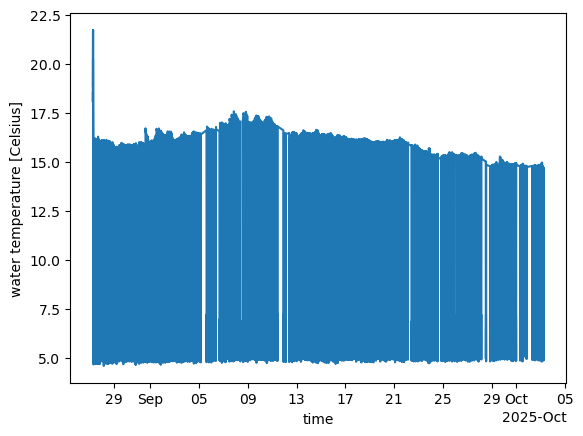

In [5]:
path = 'data/078_mission_timeseries.nc'
nrt = xr.open_dataset(path)
nrt['temperature'].plot.line()

Text(0.5, 1.0, 'Glider Track: Full Baltic Domain')

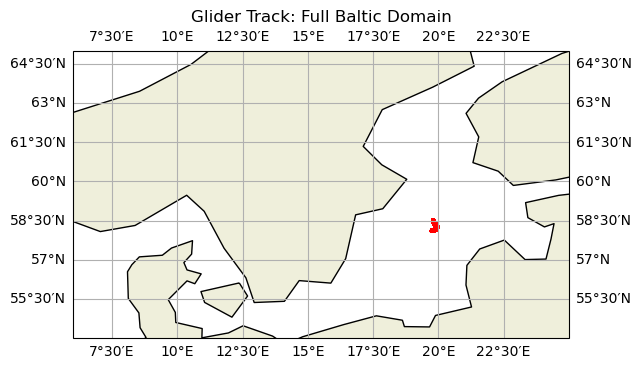

In [6]:
#   I've always had such an ugly time plotting with cartopy.
lon1 = settings["longitude"]["range"]["suspect"][0]
lon2 = settings["longitude"]["range"]["suspect"][1]
lat1 = settings["latitude"]["range"]["suspect"][0]
lat2 = settings["latitude"]["range"]["suspect"][1]
# rotated_crs = ccrs.RotatedPole(pole_longitude=120.0, pole_latitude=70.0)
ax0 = plt.axes(projection=ccrs.PlateCarree())
ax0.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax0.add_feature(cfeature.LAND.with_scale('110m'))
ax0.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax0.coastlines(resolution='110m')
ax0.scatter(nrt['longitude'], nrt['latitude'], s=5, color='red', marker="+", transform=ccrs.PlateCarree())
plt.title('Glider Track: Full Baltic Domain')

In [7]:
def plot_glider_track(ds, limits=None, pad=0.05):
    #   Limits should be [lon_min, lon_max, lat_min, lat_max], all in decimal degrees
    if limits==None:
        limits = [ds["longitude"].min(),
                  ds["longitude"].max(),
                  ds["latitude"].min(),
                  ds["latitude"].max()]
    ax0 = plt.axes(projection=ccrs.PlateCarree())
    ax0.set_extent([limits[0]-pad,
                    limits[1]+pad,
                    limits[2]-pad,
                    limits[3]+pad], crs=ccrs.PlateCarree())
    ax0.add_feature(cfeature.LAND.with_scale('110m'))
    gl = ax0.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.right_labels = False
    ax0.coastlines(resolution='110m')

    scatter = ax0.scatter(ds['longitude'], ds['latitude'], s=5, c=mdates.date2num(ds["time"]), marker="+", transform=ccrs.PlateCarree())
    
    cbar = plt.colorbar(scatter)
    cbar.ax.yaxis.set_major_formatter(
        mdates.DateFormatter('%Y-%m-%d')
    )
    cbar.ax.set_xlabel("Time")

    plt.title(f'Glider Track: {pad} degree padding')
    plt.tight_layout()

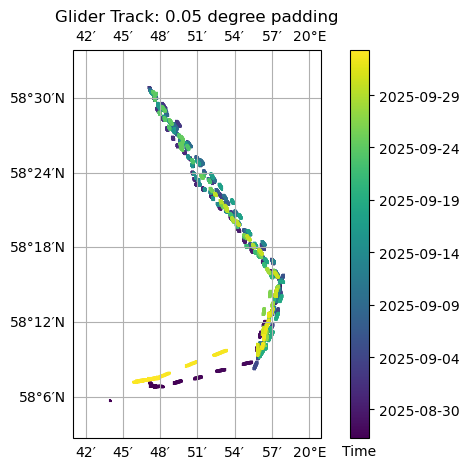

In [8]:
plot_glider_track(nrt)

In [9]:
#   A handy thing that Pandas has that xarray lacks
def xr_describe(da):
    #   For basic statistics a la pandas describe()
    #   da = Data Array
    return {
        "count": da.count().item(),
        "mean": da.mean().item(),
        "std": da.std().item(),
        "min": da.min().item(),
        "25%": da.quantile(0.25).item(),
        "50%": da.quantile(0.50).item(),
        "75%": da.quantile(0.75).item(),
        "max": da.max().item(),
    }

##  2. Set up new flags
2. Derive new flags using QARTOD standards
    * [1, 2, 3, 4, 9] = ["Good","Unchecked","Suspect or questionable","Known bad","Missing (placeholder)"]
    * Init them all *as* 2. At the end, there should be none left.

I'm breaking this up into `core_science` (what the scientists care about) and `core_pos`, which is essential positional data.

In geosciences, without knowing when and where the data point was taken, you don't really gain anything. For example, a temperature point without time or location carries no value. If there are issues in the `core_pos`, they should percholate all the way through variables in `core_science`.

In [10]:
core_science = ["temperature", "conductivity", "oxygen_concentration", "chlorophyll", "phycocyanin", "backscatter", "downwelling_PAR"] #    Note that backscatter and downwelling_PAR do not have QC currently so they will not have the other flags   
core_pos = ["time", "latitude", "longitude", "pressure"]    #   3D geospatial, plus time
flags = {"science":core_science, "pos":core_pos}
flat_flags = [item for sublist in flags.values() for item in sublist]
print(flags)

{'science': ['temperature', 'conductivity', 'oxygen_concentration', 'chlorophyll', 'phycocyanin', 'backscatter', 'downwelling_PAR'], 'pos': ['time', 'latitude', 'longitude', 'pressure']}


In [11]:
for var in flat_flags:
    qc_name = var + "_FLAG" #   Better to distinguish from _qc
    nrt[qc_name] = (nrt[var].dims, np.full(nrt[var].shape, 2, dtype=np.int8))   #   Init to 2
qc_vars_new = [name for name in nrt.data_vars if "_FLAG" in name]   #   list(nrt.variables)
qc_vars_new

['temperature_FLAG',
 'conductivity_FLAG',
 'oxygen_concentration_FLAG',
 'chlorophyll_FLAG',
 'phycocyanin_FLAG',
 'backscatter_FLAG',
 'downwelling_PAR_FLAG',
 'time_FLAG',
 'latitude_FLAG',
 'longitude_FLAG',
 'pressure_FLAG']

##  3. Spatiotemporal Checks
These are running on all of the `core_pos` flags. Some checks make more sense than others, but overall, should be pretty straightforward.

To a certain extent, each of these checks can keep Callum's tolerances `suspect` and `fail` based on some expectations.

**time**
* Boundary check, i.e., impossible dates
* Check for data gaps. I.e., differentiate it and look for odd returns.

**longitude and latitude**
* Boundary min and max
* Check for positions on land (tougher)

**pressure**
* Boundary min and max
* Check for insane descent rates (may indicate a failed sensor?). It should be differentiable and this will highlight major spikes.
* Confirm that `profile_direction` is equal to d/dt.

### Time
* Boundary check
* Data gaps and odd sample frequencies

Time is easiest to work with if we deal with seconds or fractions of seconds, rather than formatted datestrings (at least in my experience). So I'll convert our `time` variable and use that to assign flags.

In [12]:
print(settings["time"]["range"])
print(nrt.time.sel(time=slice("2025-01-01", "2025-12-31")))

{'suspect': [None, None], 'fail': [1420070400, 'NOW']}
<xarray.DataArray 'time' (time: 29094)> Size: 233kB
array(['2025-08-27T06:28:55.004999936', '2025-08-27T06:29:24.409999872',
       '2025-08-27T06:29:55.064000000', ..., '2025-10-03T06:31:02.644000000',
       '2025-10-03T06:31:32.662000128', '2025-10-03T06:32:01.000999936'],
      shape=(29094,), dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 233kB 2025-08-27T06:28:55.004999936 ... ...
    latitude   (time) float64 233kB 58.09 nan nan nan ... 58.12 58.12 58.12
    longitude  (time) float64 233kB 19.73 nan nan nan ... 19.78 19.78 19.79
    depth      (time) float64 233kB ...


In [13]:
#   Convert to numeric time
nrt['time_numeric'] = xr.DataArray(
    pd.to_datetime(nrt['time'].values).astype('int64') / 1e9,
    dims=nrt['time'].dims,
    coords=nrt['time'].coords,
    attrs={
        "units": "seconds since 1970-01-01",
        "long_name": "timestamp in seconds"
    },
)

**TODO**: These functions need:
* Logging (log.info(...completed function_name, this many 3s found, this many 4s, this many 3s overwritten by 4s, this many unique points))
* Numpy docstrings
* Consistent mypy

In [14]:
def flag_range(da, da_FLA, limits) -> xr.DataArray:
    """Applies a range test to a DataArray, flagging values in the associated FLAG DataArray.

    Parameters:
        da (xr.DataArray): The data to be tested.
        da_FLA (xr.DataArray): The FLAG DataArray associated with `da`.
        limits (dict): A dictionary with 'suspect' and 'fail' keys, each containing a list of [low, high] limits.

    Returns:
        xr.DataArray: Updated FLAG DataArray with applied flags.
    """
    s_low, s_high = [None if v == "None" else v for v in limits["suspect"]]
    f_low, f_high = [None if v == "None" else v for v in limits["fail"]]
    
    #   Deal with time - make sure the glider isn't reading the future. Convert NOW to numeric seconds.
    if s_high == "NOW":
        s_high = pd.Timestamp.now().timestamp()
    if f_high == "NOW":
        f_high = pd.Timestamp.now().timestamp()

    if s_low is not None:
        da_FLA = da_FLA.where(da >= s_low, other=np.maximum(da_FLA, 3))
    if s_high is not None:
        da_FLA = da_FLA.where(da <= s_high, other=np.maximum(da_FLA, 3))
    if f_low is not None:
        da_FLA = da_FLA.where(da >= f_low, other=4)
    if f_high is not None:
        da_FLA = da_FLA.where(da <= f_high, other=4)

    return da_FLA

In [15]:
def report_alerts(da, limits, shout=False):
    if 'alert' in limits:   #   Specific to time gaps
        alert_threshold = limits['alert']
        alert_cond = (da > alert_threshold).values
        alert_idx = np.where(alert_cond)[0]
        if len(alert_idx) > 0:
            logger.warning(f"Alert condition met for {da.name} at indices: {alert_idx}")
            if shout:
                print(f"Alert condition met for {da.name} at indices: {alert_idx}")

In [16]:
def flag_diff(da, da_FLAG, limits) -> xr.DataArray: 
    #   da = Data Array
    #   Takes a derivative and flags the second point based on the previous point.

    s_low, s_high = [None if v == "None" else v for v in limits["suspect"]]
    f_low, f_high = [None if v == "None" else v for v in limits["fail"]]
    
    diffs = da.diff(dim=da.dims[0])
    idx = {da.dims[0]: np.arange(1, da.sizes[da.dims[0]])}
    flags = da_FLAG.copy()

    # Build conditions safely, ignoring None bounds
    fail_cond = np.full_like(diffs, False, dtype=bool)
    suspect_cond = np.full_like(diffs, False, dtype=bool)

    if f_low is not None:   #   Otherwise don't do anything for unbounded mins
        fail_cond |= diffs < f_low  #   Keep existing fail flags
    if f_high is not None:
        fail_cond |= diffs > f_high

    if s_low is not None:
        suspect_cond |= diffs < s_low
    if s_high is not None:
        suspect_cond |= diffs > s_high
    
    report_alerts(diffs, limits)  #   Specific to time gaps

    # Apply flags
    flags[idx] = xr.where(fail_cond, 4, flags[idx])
    flags[idx] = xr.where((~fail_cond) & suspect_cond, 3, flags[idx])

    return flags

In [17]:
def apply_flags(original, new=None, style='cascade') -> xr.DataArray:
    """Applies new QC flags to an original FLAG DataArray based on the specified style.

    Parameters:
        original (xr.DataArray): The original FLAG DataArray.
        new (xr.DataArray): The new FLAG DataArray to be applied.
        style (str): The flagging style. Options are:
            'cascade' - takes the maximum flag between original and new, preserving the worst flag.
            'overwrite' - replaces the original flags with the new flags.
            'finalize' - when all remaining tests are done, reassigning all flags of 2 to 1.

    Returns:
        xr.DataArray: Updated FLAG DataArray with applied flags.
    """
    if new is not None:
        if style == 'cascade':
            updated_flags = xr.where(new > original, new, original)
        elif style == 'overwrite':
            updated_flags = new
    elif style == 'finalize': #  Sets all flags of 2 (good data) to 1 (final good data)
        updated_flags = xr.where(original == 2, 1, original)
    else:
        print("No new flags provided; returning original flags.")

    return updated_flags

Assuming settings are all correct, this should work

In [18]:
flags_range = flag_range(nrt.time_numeric, nrt.time_FLAG, settings["time"]["range"])    #   Run as individual tests, then merge together
flags_diff = flag_diff(nrt.time_numeric, nrt.time_FLAG, settings["time"]["dt"])
flags_combined = apply_flags(nrt.time_FLAG, flags_range)    #   Defaults to cascading flags, so the worst offenders will be kept
flags_combined = apply_flags(flags_combined, flags_diff)    #   Second batch
flags_final = apply_flags(flags_combined, style='finalize') #   Finalize flags. In the end, this would output to the netCDF as nrt.time_FLAG

WARNING: Check your settings before running %%timeit

Normally it's 5 ms or less.

In [19]:
# %%timeit    #   How long does it actually take
# flags_range = flag_range(nrt.time_numeric, nrt.time_FLAG, settings["time"]["range"])    #   Run as individual tests, then merge together
# flags_diff = flag_diff(nrt.time_numeric, nrt.time_FLAG, settings["time"]["dt"])
# flags_combined = apply_flags(nrt.time_FLAG, flags_range, style='cascade')

Let's break down what these did in the notebook and make sure they're working correctly.

#### Range check on time

<xarray.DataArray 'time_FLAG' ()> Size: 8B
array(0)


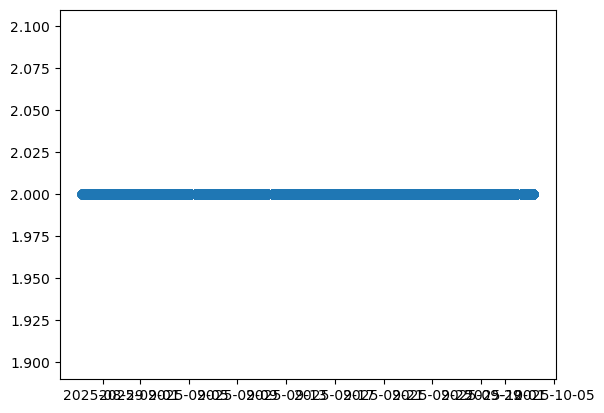

In [20]:
#   Confirm that our flags are set up
print((flags_range != 2).sum())
plt.scatter(nrt.time, flags_range)

In [21]:
print(f"The raw time {nrt.time.min().item()}")
print(f"Converts to this many seconds: {nrt.time_numeric.min().item()}")
print(settings["time"]["range"])
print(f"(Now is {pd.Timestamp.now().timestamp()})")
print(f"Success, as the numeric time {nrt.time_numeric.min().item()} > {settings["time"]["range"]['fail'][0]}")
print(f"And {nrt.time_numeric.min().item()} < {settings["time"]["range"]['fail'][1]} = {pd.Timestamp.now().timestamp()}")

The raw time 1756276135004999936
Converts to this many seconds: 1756276135.0049999
{'suspect': [None, None], 'fail': [1420070400, 'NOW']}
(Now is 1765458388.313023)
Success, as the numeric time 1756276135.0049999 > 1420070400
And 1756276135.0049999 < NOW = 1765458388.314309


This means that none of the times from this check had actually found anything outside of the specified ranges. 

Argo's QC document (3.9) suggests that we should use UTC present time as the upper bound. That's why I've hardcoded how to handle "NOW" into the `qc_settings.yml`.

All the timestamps inside are within the ranges and no flags were changed - this test has been passed.

####    IMOS impossible date test
IMOS uses their bounds of `deployment_start_date` and `deployment_end_date`, which here are nrt.attrs that we've saved.
* nrt.attrs["deployment_start"] and ["deployment_end"]
* nrt.attrs["time_coverage_start"] and ["time_coverage_end"] are in here, too. They're identical here, not sure what the difference is.

Anything outside of this range yets removed from the dataset.

In [22]:
print(nrt.attrs["deployment_start"],nrt.attrs["deployment_end"])
print(nrt.attrs["time_coverage_start"],nrt.attrs["time_coverage_end"])

2025-08-27T06:28:55.005000000 2025-10-03T06:32:01.001000000
2025-08-27T06:28:55.005000000 2025-10-03T06:32:01.001000000


In [23]:
lims = [nrt.attrs["deployment_start"],nrt.attrs["deployment_end"]]
lims

['2025-08-27T06:28:55.005000000', '2025-10-03T06:32:01.001000000']

In [24]:
report_alerts(nrt.time, lims, shout=True)

Nothing was written out, which is what we saw in our other test as well. In the future, we may want to pull these ranges from the attributes rather than something we manually define.

#### d/dt check on time

<xarray.DataArray 'time_FLAG' ()> Size: 8B
array(440)


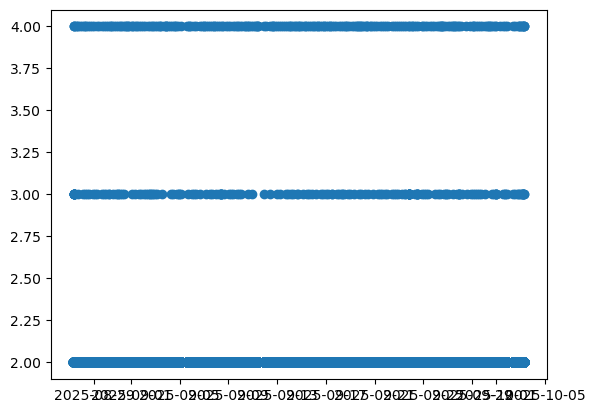

In [25]:
print((flags_diff != 2).sum())
plt.scatter(nrt.time, flags_diff)

Clearly, this one flagged a lot of stuff. There are 440 points which were either bad or questionable. Let's run through this.

In [26]:
#   Build the workspace within the function
da = nrt.time_numeric
da_FLAG = nrt.time_FLAG
limits = settings["time"]["dt"]
print(limits)
s_low, s_high = [None if v == "None" else v for v in limits["suspect"]]
f_low, f_high = [None if v == "None" else v for v in limits["fail"]]
print(s_low, s_high, f_low, f_high)

{'suspect': [25, 35], 'fail': [5, 60], 'alert': 1000}
25 35 5 60


In [27]:
diffs = da.diff(dim=da.dims[0])
diffs = diffs.pad({da.dims[0]: (1, 0)}, constant_values=np.nan)   #   Pad the diff to match original length
idx = {da.dims[0]: np.arange(1, da.sizes[da.dims[0]])}
flags = da_FLAG.copy()

In [28]:
print(diffs[0].item())
print(diffs[1].item())  #   Expecting something close to 30 seconds

nan
29.40499997138977


In [29]:
fail_cond = np.full_like(diffs, False, dtype=bool)
suspect_cond = np.full_like(diffs, False, dtype=bool)

#   First check, looking at the fail conditions
if f_low is not None:
    fail_cond |= diffs < f_low
if f_high is not None:
    fail_cond |= diffs > f_high

Ok, so now that we've run the step that normally IDs where the failures are, let's pause and check on them.

#####   Known failures

In [30]:
any(fail_cond)

True

In [31]:
idx = fail_cond.values.nonzero()
print(len(idx[0]))  #   Indicating how many egregious diffs there are
print(idx)

255
(array([  107,   108,   205,   329,   483,   484,   636,   801,   967,
        1131,  1132,  1294,  1452,  1604,  1755,  1905,  2052,  2192,
        2325,  2454,  2580,  2701,  2810,  2811,  2929,  3036,  3140,
        3239,  3349,  3464,  3584,  3705,  3706,  3823,  3824,  3948,
        4080,  4081,  4213,  4348,  4349,  4486,  4618,  4754,  4893,
        5018,  5131,  5238,  5353,  5476,  5601,  5734,  5735,  5882,
        6031,  6184,  6185,  6186,  6340,  6500,  6666,  6834,  6835,
        7001,  7171,  7342,  7492,  7639,  7640,  7781,  7919,  8048,
        8157,  8277,  8383,  8384,  8494,  8606,  8728,  8853,  8975,
        8976,  9103,  9246,  9511,  9512,  9651,  9784,  9926, 10069,
       10195, 10311, 10422, 10535, 10658, 10786, 10928, 10929, 11073,
       11075, 11225, 11384, 11555, 11722, 11723, 11891, 11892, 11893,
       12045, 12200, 12352, 12495, 12496, 12497, 12637, 12771, 12900,
       13021, 13142, 13255, 13367, 13485, 13486, 13600, 13706, 13800,
       13898, 1

Ok, so we found plenty of flags. What do the values of ddt look like at this point?

In [32]:
diffs[idx]

<xarray.DataArray 'time_numeric' (time: 255)> Size: 2kB
array([6.01790001e+01, 2.72700000e+00, 6.01700001e+01, 8.94427500e+03,
       3.50499988e+00, 9.23654700e+03, 1.00649400e+04, 9.82537200e+03,
       1.01201920e+04, 1.93199992e+00, 9.69432300e+03, 1.04790470e+04,
       9.59524600e+03, 9.39551600e+03, 9.22145300e+03, 1.33820300e+04,
       1.28347830e+04, 1.22874350e+04, 1.16277220e+04, 1.18177630e+04,
       1.14736830e+04, 1.05441700e+04, 1.22870000e+02, 1.10268200e+04,
       1.06990850e+04, 9.93566900e+03, 9.58886800e+03, 9.74372200e+03,
       1.03699910e+04, 1.05176510e+04, 1.08280590e+04, 1.49700022e+00,
       1.08354320e+04, 2.72099996e+00, 1.08218920e+04, 1.23652500e+04,
       3.59999990e+00, 1.24352600e+04, 1.20739400e+04, 8.96840000e+01,
       1.23679770e+04, 1.17806620e+04, 1.20766480e+04, 1.20771180e+04,
       1.14785340e+04, 1.07924980e+04, 9.77904000e+03, 7.43988900e+03,
       9.79851300e+03, 1.12041080e+04, 1.14493850e+04, 6.24000072e-01,
       1.26018910e+04, 1.30973630e+04, 9.20820700e+03, 9.64520001e+01,
       1.49499989e+00, 9.86676700e+03, 9.70273800e+03, 1.04510860e+04,
       1.00501660e+04, 9.16120000e+01, 1.02659110e+04, 1.03232630e+04,
       1.00688450e+04, 3.95528560e+04, 9.41738800e+03, 7.09610000e+01,
       1.29467830e+04, 1.27727430e+04, 1.15364900e+04, 2.48330670e+04,
       1.04641940e+04, 1.01847500e+04, 6.51640000e+01, 9.83013000e+03,
       9.94647700e+03, 1.08056560e+04, 1.09372450e+04, 1.15748310e+04,
...
       1.23515300e+04, 1.14783170e+04, 1.13852730e+04, 1.12005340e+04,
       1.00102050e+04, 2.38362960e+04, 9.47780900e+03, 1.00327180e+04,
       1.09362930e+04, 1.13300720e+04, 1.17139410e+04, 1.20989130e+04,
       1.17892430e+04, 1.24883050e+04, 6.13350003e+01, 1.26424770e+04,
       1.47299981e+00, 1.21836490e+04, 1.18675780e+04, 1.46200013e+00,
       2.45669970e+04, 1.01912720e+04, 1.08236600e+04, 1.09071170e+04,
       1.12936800e+04, 1.28259750e+04, 1.32377250e+04, 1.50075630e+04,
       9.88200100e+03, 3.24499989e+00, 9.67002400e+03, 1.12559000e+02,
       1.29299998e+00, 1.00447210e+04, 1.01954200e+04, 1.07051640e+04,
       1.02105380e+04, 1.01790760e+04, 1.12399983e+00, 9.96245600e+03,
       2.82099986e+00, 9.90280800e+03, 9.48289100e+03, 3.14300013e+00,
       1.36347930e+04, 3.00598980e+04, 2.68214590e+04, 1.08342360e+04,
       2.83199978e+00, 9.72797600e+03, 1.04882090e+04, 1.06201010e+04,
       1.08835460e+04, 1.14218440e+04, 1.24558010e+04, 1.33725400e+04,
       3.15700006e+00, 9.31105300e+03, 9.47479999e+01, 9.35251300e+03,
       9.71656800e+03, 9.85008400e+03, 4.00700021e+00, 2.57097790e+04,
       1.01803880e+04, 9.67716800e+03, 9.71929600e+03, 3.76254690e+04,
       1.01765440e+04, 1.48343790e+04, 6.35032000e+03, 9.55020001e+01,
       6.17603300e+03, 6.21337200e+03, 1.01045000e+02, 3.76699996e+00,
       4.11199999e+00, 2.44899988e+00, 6.00950000e+01])
Coordinates:
  * time       (time) datetime64[ns] 2kB 2025-08-27T07:21:56.608000 ... 2025-...
    latitude   (time) float64 2kB 58.12 58.12 58.11 nan ... 58.12 nan 58.12
    longitude  (time) float64 2kB 19.79 19.79 19.79 nan ... 19.8 19.79 nan 19.79
    depth      (time) float64 2kB 1.651 1.689 1.631 2.023 ... 1.881 1.841 1.965

In [33]:
limits

{'suspect': [25, 35], 'fail': [5, 60], 'alert': 1000}

From this output, we can see that pretty much everything is an order of magnitude off. +e04 is pretty common. And when we consider our cutoff limits, it's obvious that many of these points are A-ok.

Text(0, 0.5, 'Numeric time (s since 1970-01-01)')

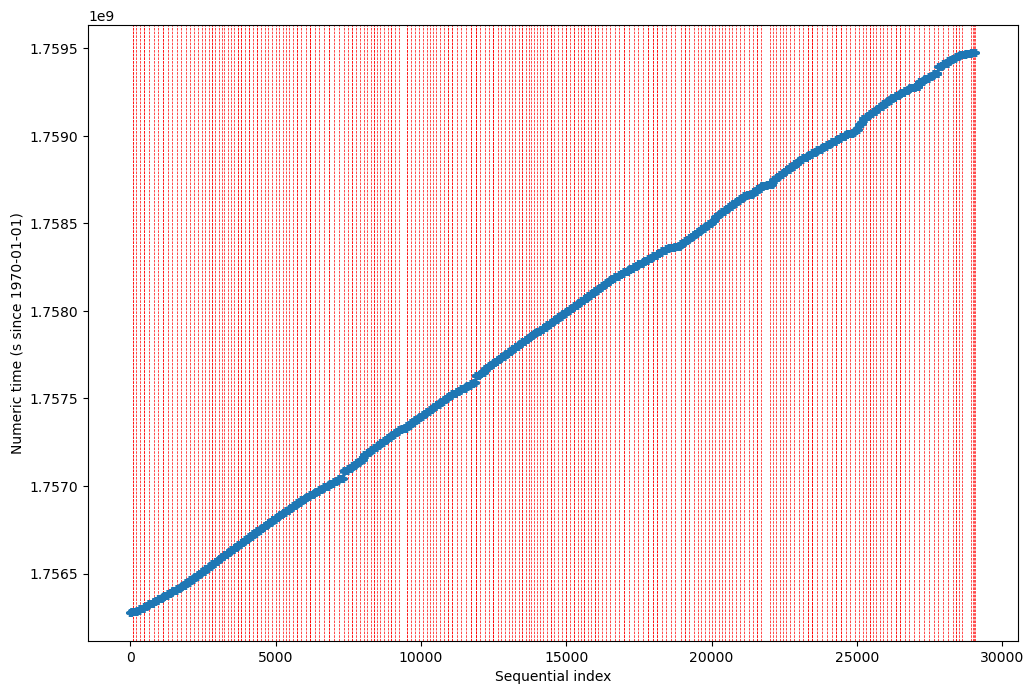

In [34]:
plt.figure(figsize=(12, 8))
plt.scatter(np.arange(nrt.time_numeric.size), nrt.time_numeric, marker='+', zorder=2)
for i in np.where(flags_diff.values == 4)[0]:
    plt.axvline(i, linestyle='--', linewidth=0.5, color='red', zorder=1)
plt.xlabel('Sequential index')
plt.ylabel('Numeric time (s since 1970-01-01)')

...make it interactive so we can see what we're really working with.

In [35]:
x = np.arange(nrt.time_numeric.size)
y = nrt.time_numeric.values

# indices where flags_diff ==4
bad_idx = np.where(flags_diff.values == 4)[0]

p = figure(
    width=1000,
    height=600,
    x_axis_label="Sequential index",
    y_axis_label="Numeric time (s since 1970-01-01)",
    tools="pan,wheel_zoom,box_zoom,reset"
)

# scatter points
p.scatter(x, y, marker="+", size=8)

# vertical dashed lines (placed *behind* the glyphs)
for i in bad_idx:
    vline = Span(location=i,
                 dimension='height',
                 line_dash='dashed',
                 line_color='red',
                 line_width=1,
                 level='underlay')   # ensures lines appear behind scatter
    p.add_layout(vline)
show(p)

This kind of figure is what I think we can include in our report. It shows where there might be **data gaps** or **stumbles** in reporting frequency.

Alas, I think this works (at least with the limits we have defined). Let's move on to the suspect points.

#####   Looking at suspect points

In [36]:
if s_low is not None:
    suspect_cond |= diffs < s_low
if s_high is not None:
    suspect_cond |= diffs > s_high

In [37]:
any(suspect_cond)

True

In [38]:
idx = suspect_cond.values.nonzero()
print(len(idx[0]))  #   Indicating how many suspect points there are, which includes everything from fail_cond (as boundaries are tighter here)
print(idx)

440
(array([   93,    94,   105,   106,   107,   108,   112,   197,   198,
         203,   204,   205,   328,   329,   483,   484,   635,   636,
         801,   966,   967,  1130,  1131,  1132,  1293,  1294,  1451,
        1452,  1604,  1754,  1755,  1904,  1905,  2051,  2052,  2192,
        2324,  2325,  2453,  2454,  2579,  2580,  2699,  2700,  2701,
        2810,  2811,  2928,  2929,  3036,  3139,  3140,  3237,  3238,
        3239,  3348,  3349,  3463,  3464,  3583,  3584,  3705,  3706,
        3823,  3824,  3948,  4079,  4080,  4081,  4212,  4213,  4348,
        4349,  4485,  4486,  4617,  4618,  4753,  4754,  4892,  4893,
        5017,  5018,  5129,  5130,  5131,  5237,  5238,  5352,  5353,
        5475,  5476,  5600,  5601,  5734,  5735,  5881,  5882,  6031,
        6184,  6185,  6186,  6340,  6499,  6500,  6665,  6666,  6834,
        6835,  7000,  7001,  7169,  7170,  7171,  7341,  7342,  7491,
        7492,  7639,  7640,  7780,  7781,  7918,  7919,  8047,  8048,
        8156,  

In [39]:
diffs[idx]

<xarray.DataArray 'time_numeric' (time: 440)> Size: 4kB
array([1.83939998e+01, 1.49060001e+01, 1.92570000e+01, 1.07659998e+01,
       6.01790001e+01, 2.72700000e+00, 5.97500000e+01, 1.40650001e+01,
       1.87679999e+01, 2.42040000e+01, 5.81299996e+00, 6.01700001e+01,
       8.76499987e+00, 8.94427500e+03, 3.50499988e+00, 9.23654700e+03,
       1.97200000e+01, 1.00649400e+04, 9.82537200e+03, 2.14570000e+01,
       1.01201920e+04, 3.59470000e+01, 1.93199992e+00, 9.69432300e+03,
       2.37619998e+01, 1.04790470e+04, 6.99399996e+00, 9.59524600e+03,
       9.39551600e+03, 2.46250002e+01, 9.22145300e+03, 2.07830000e+01,
       1.33820300e+04, 4.22200000e+01, 1.28347830e+04, 1.22874350e+04,
       2.31459999e+01, 1.16277220e+04, 6.99100018e+00, 1.18177630e+04,
       1.78090000e+01, 1.14736830e+04, 3.82610002e+01, 6.96199989e+00,
       1.05441700e+04, 1.22870000e+02, 1.10268200e+04, 1.70339997e+01,
       1.06990850e+04, 9.93566900e+03, 1.14920001e+01, 9.58886800e+03,
       3.74480000e+01, 9.92799997e+00, 9.74372200e+03, 1.71039999e+01,
       1.03699910e+04, 2.19209998e+01, 1.05176510e+04, 8.82399988e+00,
       1.08280590e+04, 1.49700022e+00, 1.08354320e+04, 2.72099996e+00,
       1.08218920e+04, 1.23652500e+04, 3.84800000e+01, 3.59999990e+00,
       1.24352600e+04, 4.23569999e+01, 1.20739400e+04, 8.96840000e+01,
       1.23679770e+04, 1.44090002e+01, 1.17806620e+04, 2.40320001e+01,
       1.20766480e+04, 1.58499999e+01, 1.20771180e+04, 2.13349998e+01,
...
       1.01790760e+04, 4.18020003e+01, 1.12399983e+00, 9.96245600e+03,
       2.82099986e+00, 9.90280800e+03, 1.90320001e+01, 9.48289100e+03,
       4.11090000e+01, 3.14300013e+00, 1.70140002e+01, 2.40750000e+01,
       3.76650000e+01, 1.36347930e+04, 2.32790000e+01, 3.00598980e+04,
       1.25279999e+01, 2.68214590e+04, 1.32490001e+01, 1.08342360e+04,
       5.17330000e+01, 2.83199978e+00, 9.72797600e+03, 4.09660001e+01,
       1.04882090e+04, 6.59299994e+00, 1.06201010e+04, 1.49480000e+01,
       1.08835460e+04, 1.42350001e+01, 1.14218440e+04, 1.24558010e+04,
       1.55139999e+01, 1.33725400e+04, 3.15700006e+00, 9.31105300e+03,
       9.47479999e+01, 9.35251300e+03, 1.17350001e+01, 9.71656800e+03,
       5.14050000e+01, 9.85008400e+03, 1.56600001e+01, 1.79159999e+01,
       4.00700021e+00, 5.58870001e+01, 1.90410004e+01, 2.57097790e+04,
       1.01803880e+04, 1.46069999e+01, 9.67716800e+03, 3.61250002e+01,
       6.77699995e+00, 9.71929600e+03, 1.54119999e+01, 3.76254690e+04,
       7.14499998e+00, 1.01765440e+04, 4.11339998e+01, 1.48343790e+04,
       3.62279999e+01, 8.15199995e+00, 6.35032000e+03, 9.55020001e+01,
       8.09500003e+00, 6.17603300e+03, 1.59539998e+01, 6.21337200e+03,
       1.01045000e+02, 5.14599991e+00, 7.23399997e+00, 2.29030001e+01,
       7.03900003e+00, 2.24240000e+01, 3.76699996e+00, 4.11199999e+00,
       2.44899988e+00, 2.18110001e+01, 8.21499991e+00, 6.00950000e+01])
Coordinates:
  * time       (time) datetime64[ns] 4kB 2025-08-27T07:15:15.001999872 ... 20...
    latitude   (time) float64 4kB 58.12 58.12 58.12 58.12 ... 58.12 58.12 58.12
    longitude  (time) float64 4kB 19.79 19.79 19.79 19.79 ... 19.79 19.79 19.79
    depth      (time) float64 4kB 1.712 1.63 1.657 1.695 ... 1.924 1.89 1.965

In [40]:
limits

{'suspect': [25, 35], 'fail': [5, 60], 'alert': 1000}

Understandably, there are more points that are flagged here because the bounds are tighter. A diff of 10, for example, will now show up, but will get flagged differently from say, a 2.5, which was also in `fail_cond`.

In [41]:
x = np.arange(nrt.time_numeric.size)
y = nrt.time_numeric.values

sus_idx = np.where(flags_diff.values == 3)[0]
bad_idx = np.where(flags_diff.values == 4)[0]
diffs_vals = diffs.values

source = ColumnDataSource(data=dict(
    x=x,
    y=y,
    diffs=diffs_vals
))  #   For the diffs

p = figure(
    width=1000,
    height=600,
    x_axis_label="Sequential index",
    y_axis_label="Numeric time (s since 1970-01-01)",
    tools="pan,wheel_zoom,box_zoom,reset"
)

p.scatter('x', 'y', source=source, marker="+", size=8)

for i in sus_idx:
    vline = Span(location=i,
                 dimension='height',
                 line_dash='dashed',
                 line_color='blue',
                 line_width=1,
                 level='underlay')   # ensures lines appear behind scatter
    p.add_layout(vline)
for i in bad_idx:
    vline = Span(location=i,
                 dimension='height',
                 line_dash='dashed',
                 line_color='red',
                 line_width=1,
                 level='underlay')   # ensures lines appear behind scatter
    p.add_layout(vline)

hover = HoverTool(tooltips=[
    ("Index", "@x"),
    ("Numeric time (s)", "@y"),
    ("Diff value", "@diffs"),
])
p.add_tools(hover)

show(p)

So this looks good. Zooming in, I can tell where the flags are being adjusted and blue=3 shows a diff value that is within the suspect limits.

The final bit of code, which assigns the flags, wraps it all up.
```
    # Apply flags
    flags[idx] = xr.where(fail_cond, 4, flags[idx])
    flags[idx] = xr.where((~fail_cond) & suspect_cond, 3, flags[idx])

    return flags
```
Apply 4s first, then apply the `suspect_cond` 3s where there aren't 4s.

#### Merge them all together


<xarray.DataArray 'time_FLAG' ()> Size: 8B
array(440)


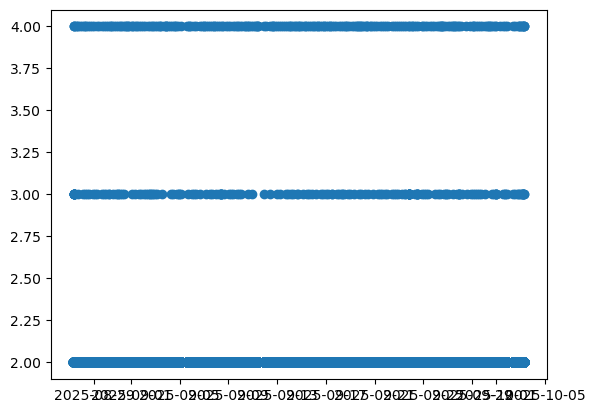

In [42]:
print((flags_combined != 2).sum())
plt.scatter(nrt.time, flags_combined)

<xarray.DataArray 'time_FLAG' ()> Size: 8B
array(29094)


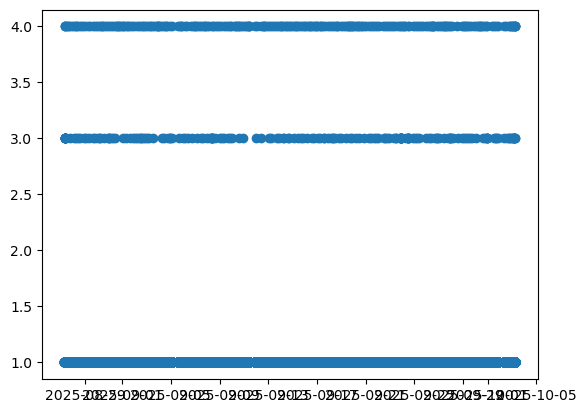

In [43]:
print((flags_final != 2).sum()) #   Prove that we don't have any more 2's
plt.scatter(nrt.time, flags_final)

Just like that, not a single flag is a 2.

QC has never been done for `time`, so I think the only flags that we would really even care about reporting would be the ones that are out of bounds. But even then, it's something that I think we should only really be reporting and it's kind of its own thing. The most important things are the data gap cutoffs.

I've added a line to `flag_diff` for that reason, it will now be reported in the logfile.

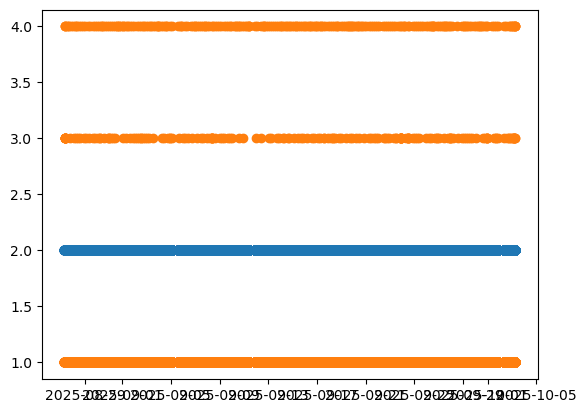

In [44]:
plt.scatter(nrt.time, nrt.time_FLAG)
plt.scatter(nrt.time, flags_final)

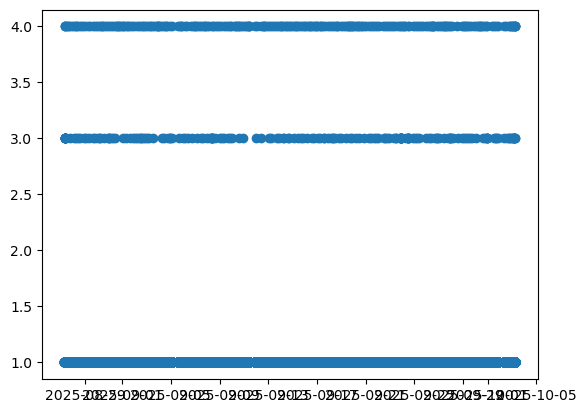

In [45]:
nrt.time_FLAG.data = flags_final.data   #   Update the original dataset with the new flags
plt.scatter(nrt.time, nrt.time_FLAG)

### Lat and Lon
* Boundary min and max
* Look for jumps - this is kind of like the Argo speed test
* Check for positions on land (tougher) - Argo and IMOS suggest downloading a 5-minute bathymetry file
    * Doesn't cartopy support this? To look into later.

At this point, we already have defined `flag_range`, `flag_diffs`, and `apply_flags`. But this time, we actually have some pressure QC to compare our new flags to.

In [46]:
print(settings["latitude"])
print(settings["longitude"])
#   Recall, latitude and longitude are decimal degrees + and -, almost exclusively positive with respect to the Baltic sea.

{'range': {'suspect': [54, 65], 'fail': [-90, 90]}, 'dt': {'suspect': [-0.0001, 0.0001], 'fail': [-0.001, 0.001]}}
{'range': {'suspect': [6, 25], 'fail': [-180, 180]}, 'dt': {'suspect': [-0.0001, 0.0001], 'fail': [-0.001, 0.001]}}


####    Latitude
Originally I had my limits set to
```
latitude:
  range:
    suspect: [54, 65]
    fail: [-90, 90]
  dt: 
    suspect: [None, 0.5]  # 
    fail: [None, 5]
```
And the results didn't catch anything at all. I changed them to
```
latitude:
  range:
    suspect: [54, 65]
    fail: [-90, 90]
  dt: 
    suspect: [-0.0001, 0.0001]  # 
    fail: [-0.001, 0.001]
```
And now the lower bound is catching stuff the way `flag_qartod` does. It's not exactly the same, as that's a spike algorithm, but it's nice to see this works.

Something important to note is that many of these values are **NaN** and should get flagged accordingly in post. It could also be an artifact of testing things out on NRT data, rather than the real-deal.

In [47]:
def flag_nan(da, da_FLAG) -> xr.DataArray:
    #   Flags all NaN values as 9 (missing as per QARTOD)
    flags = da_FLAG.copy()
    nan_cond = np.isnan(da)
    flags = xr.where(nan_cond, 9, flags)
    return flags

In [48]:
settings = load_settings()  #   Good to periodically reload this.
flags_range = flag_range(nrt.latitude, nrt.latitude_FLAG, settings["latitude"]["range"])
flags_diff = flag_diff(nrt.latitude, nrt.latitude_FLAG, settings["latitude"]["dt"])
flags_nan = flag_nan(nrt.latitude, nrt.latitude_FLAG)

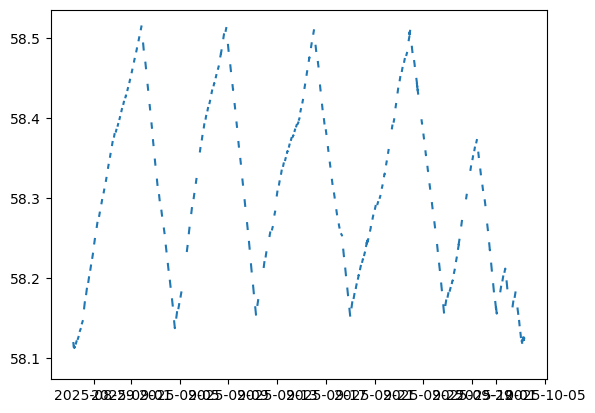

In [49]:
plt.plot(nrt.time, nrt.latitude, linestyle='-') #   This is what we're dealing with

Unlike time, we have seen QC on the latitude parameter before. This gives us an opporitunity to do more comparisons.

Before merging them together, let's see if there were any particular agreements between these methods.

1041 total flags from current test


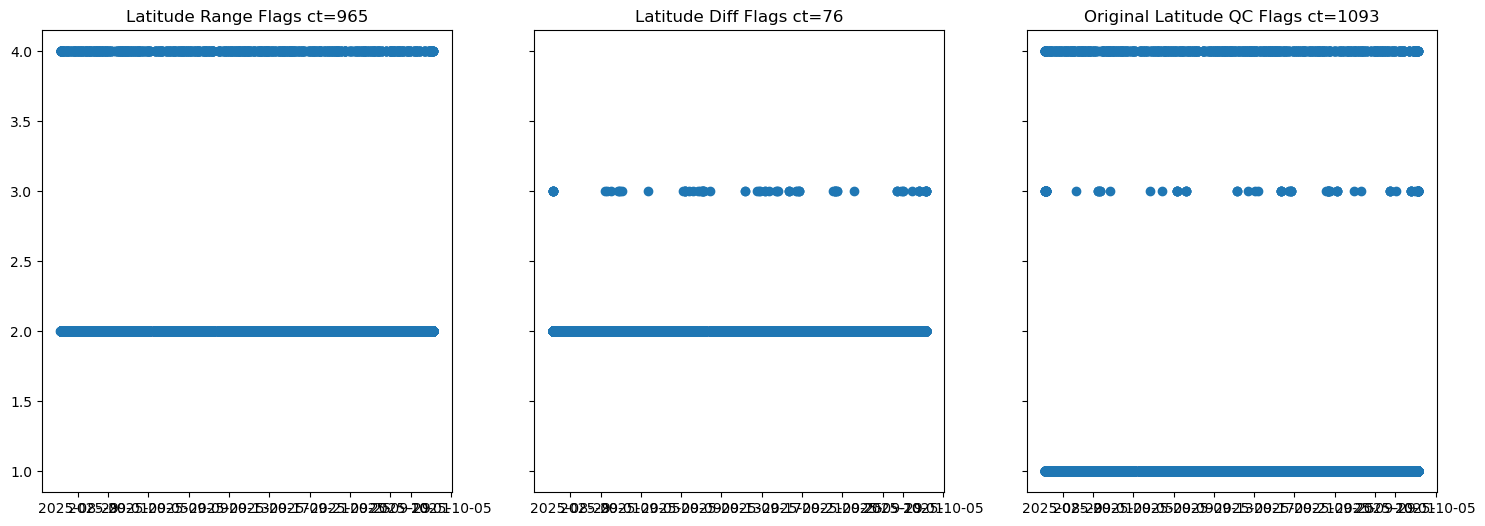

In [50]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
axs[0].scatter(nrt.time, flags_range.values)
axs[0].set_title(f'Latitude Range Flags ct={(flags_range != 2).sum().item()}')
axs[1].scatter(nrt.time, flags_diff.values)
axs[1].set_title(f'Latitude Diff Flags ct={(flags_diff != 2).sum().item()}')
axs[2].scatter(nrt.time, nrt.latitude_qc)  #   Original flags, this one caught stuff.
axs[2].set_title(f'Original Latitude QC Flags ct={(nrt.latitude_qc != 1).sum().item()}') #  Ignore the "good"
print(f"{(flags_range != 2).sum().item()+(flags_diff != 2).sum().item()} total flags from current test")

Good to show how many areas where they agree.

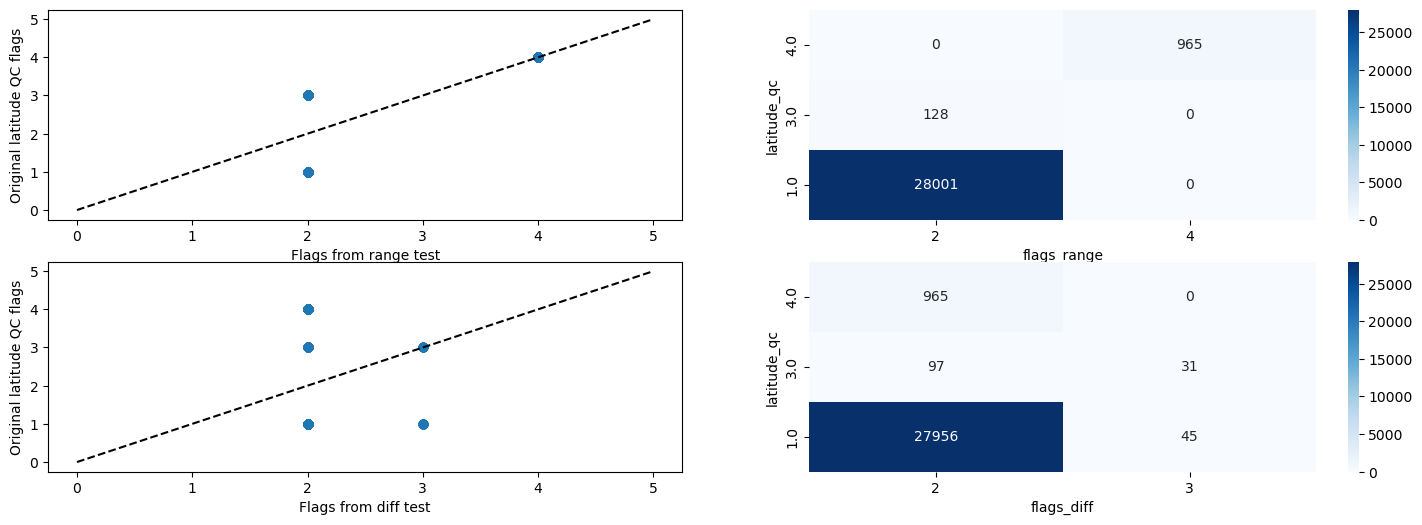

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(18, 6))
axs[0,0].scatter(flags_range.values, nrt.latitude_qc)
axs[0,0].plot([0, 5], [0, 5], linestyle='--', color='k')
axs[0,0].set_xlabel('Flags from range test')
axs[0,0].set_ylabel('Original latitude QC flags')
axs[1,0].scatter(flags_diff.values, nrt.latitude_qc)
axs[1,0].plot([0, 5], [0, 5], linestyle='--', color='k')
axs[1,0].set_xlabel('Flags from diff test')
axs[1,0].set_ylabel('Original latitude QC flags')

conf_matrix_range = pd.crosstab(nrt.latitude_qc, flags_range)
conf_matrix_diff  = pd.crosstab(nrt.latitude_qc, flags_diff)
sns.heatmap(conf_matrix_range, annot=True, fmt='d', cmap='Blues', ax=axs[0,1])
axs[0,1].set_ylabel('latitude_qc')
axs[0,1].set_xlabel('flags_range')
axs[0,1].invert_yaxis()

sns.heatmap(conf_matrix_diff, annot=True, fmt='d', cmap='Blues', ax=axs[1,1])
axs[1,1].set_ylabel('latitude_qc')
axs[1,1].set_xlabel('flags_diff')
axs[1,1].invert_yaxis()

In [52]:
flags_combined = apply_flags(nrt.latitude_FLAG, flags_range)    #   Defaults to cascading flags, so the worst offenders will be kept
flags_combined = apply_flags(flags_combined, flags_diff)    #   Second batch
flags_combined = apply_flags(flags_combined, flags_nan)    #   Third batch
flags_final = apply_flags(flags_combined, style='finalize')

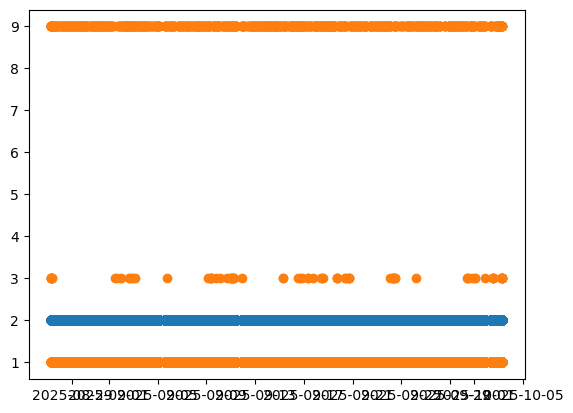

In [53]:
plt.scatter(nrt.time, nrt.latitude_FLAG)
plt.scatter(nrt.time, flags_final)

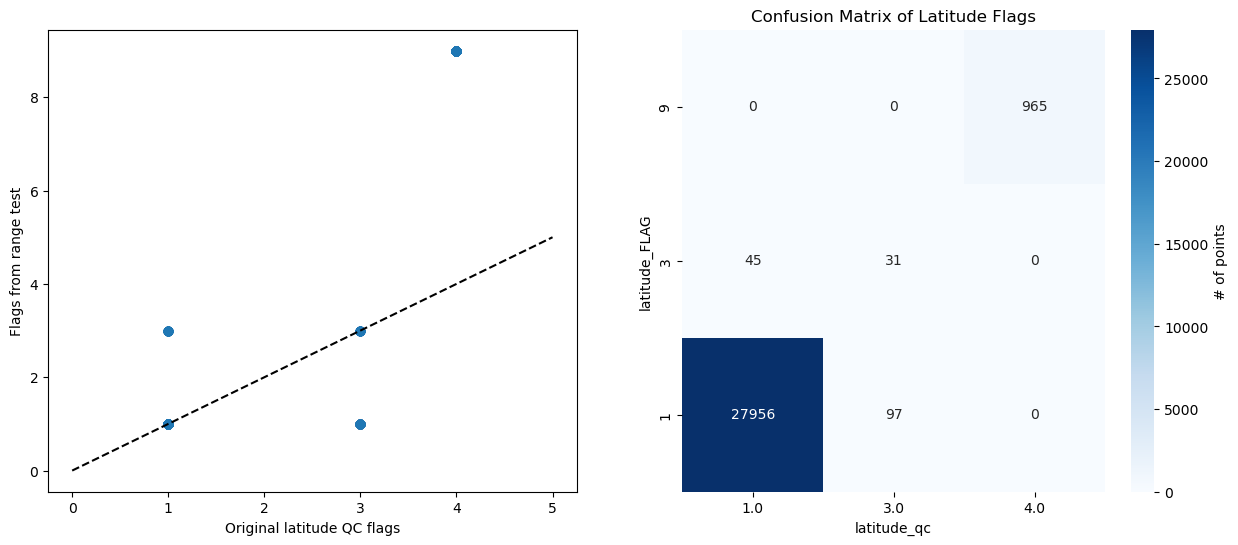

In [54]:
nrt.latitude_FLAG.data = flags_final.data
conf_matrix = pd.crosstab(nrt.latitude_FLAG, nrt.latitude_qc)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].scatter(nrt.latitude_qc, nrt.latitude_FLAG)
axs[0].plot([0, 5], [0, 5], linestyle='--', color='k')
axs[0].set_ylabel('Flags from range test')
axs[0].set_xlabel('Original latitude QC flags')

axs[1] = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
axs[1].set_xlabel('latitude_qc')
axs[1].set_ylabel('latitude_FLAG')
axs[1].set_title('Confusion Matrix of Latitude Flags')
axs[1].invert_yaxis()  #   So that 0 is at the bottom
cbar = axs[1].collections[0].colorbar
cbar.set_label('# of points')

In [55]:
# plt.plot(nrt.time, nrt.latitude, linestyle='-') #   This is what we're dealing with
varname = 'latitude'
x = np.arange(nrt.time.size)
y = nrt[varname].values

sus_idx = np.where(nrt.latitude_FLAG.values == 3)[0]
bad_idx = np.where(nrt.latitude_FLAG.values == 4)[0]

source = ColumnDataSource(data=dict(
    x=x,
    y=y,
    diffs=diffs_vals
))  #   For the diffs

p = figure(
    width=1000,
    height=600,
    x_axis_label="Sequential index",
    y_axis_label=varname,
    tools="pan,wheel_zoom,box_zoom,reset"
)

p.scatter('x', 'y', source=source, marker="+", size=8)

for i in sus_idx:
    vline = Span(location=i,
                 dimension='height',
                 line_dash='dashed',
                 line_color='blue',
                 line_width=1,
                 level='underlay')   # ensures lines appear behind scatter
    p.add_layout(vline)
for i in bad_idx:
    vline = Span(location=i,
                 dimension='height',
                 line_dash='dashed',
                 line_color='red',
                 line_width=1,
                 level='underlay')   # ensures lines appear behind scatter
    p.add_layout(vline)

hover = HoverTool(tooltips=[
    ("Index", "@x"),
    (f"{varname}", "@y")
])
p.add_tools(hover)

show(p)

####    Longitude
Ok, do we have a system yet?
* Flag the stuff, show off the settings
* Show the different distributions of flags
* Merge them, show generic + interactive plot

Text(0, 0.5, 'longitude')

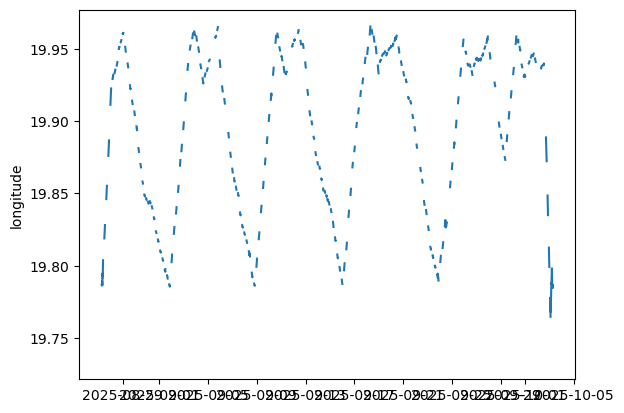

In [56]:
settings = load_settings()  #   Good to periodically reload this.
varname = 'longitude'
flagname= f"{varname}_FLAG"
origflag= f"{varname}_qc"
flags_range = flag_range(nrt[varname], nrt[flagname], settings[varname]["range"])
flags_diff = flag_diff(nrt[varname], nrt[flagname], settings[varname]["dt"])
flags_nan = flag_nan(nrt[varname], nrt[flagname])
plt.plot(nrt.time, nrt[varname], linestyle='-') #   This is what we're dealing with
plt.ylabel(varname)

1668 total flags from current test


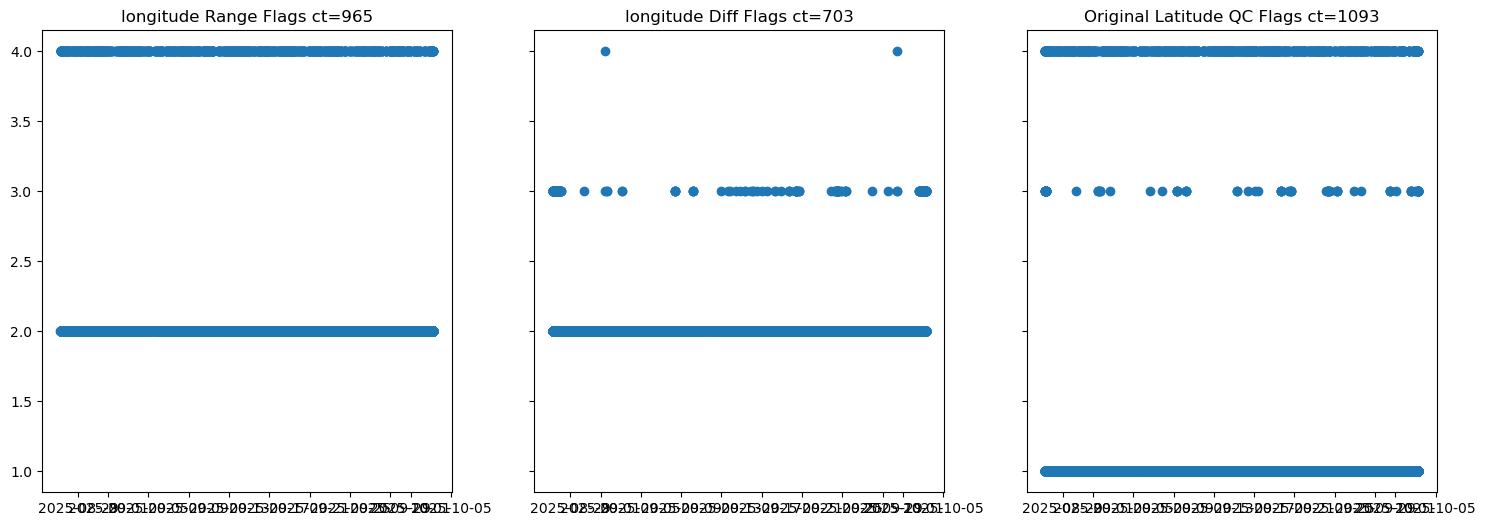

In [57]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
axs[0].scatter(nrt.time, flags_range.values)
axs[0].set_title(f'{varname} Range Flags ct={(flags_range != 2).sum().item()}')
axs[1].scatter(nrt.time, flags_diff.values)
axs[1].set_title(f'{varname} Diff Flags ct={(flags_diff != 2).sum().item()}')
axs[2].scatter(nrt.time, nrt[origflag])  #   Original flags, this one caught stuff.
axs[2].set_title(f'Original Latitude QC Flags ct={(nrt[origflag] != 1).sum().item()}') #  Ignore the "good"
print(f"{(flags_range != 2).sum().item()+(flags_diff != 2).sum().item()} total flags from current test")

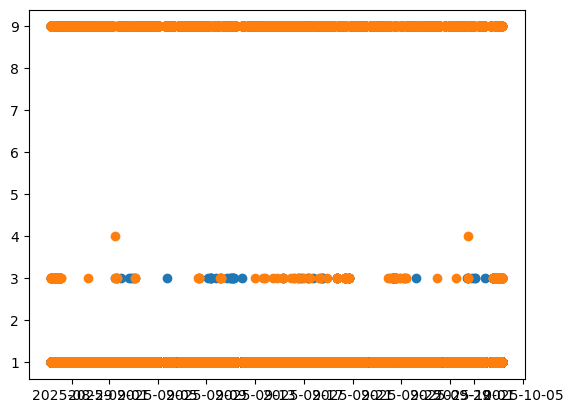

In [58]:
flags_combined = apply_flags(nrt[flagname], flags_range)    #   Defaults to cascading flags, so the worst offenders will be kept
flags_combined = apply_flags(flags_combined, flags_diff)    #   Second batch
flags_combined = apply_flags(flags_combined, flags_nan)    #   Third batch
flags_final = apply_flags(flags_combined, style='finalize')
plt.scatter(nrt.time, nrt.latitude_FLAG)
plt.scatter(nrt.time, flags_final)

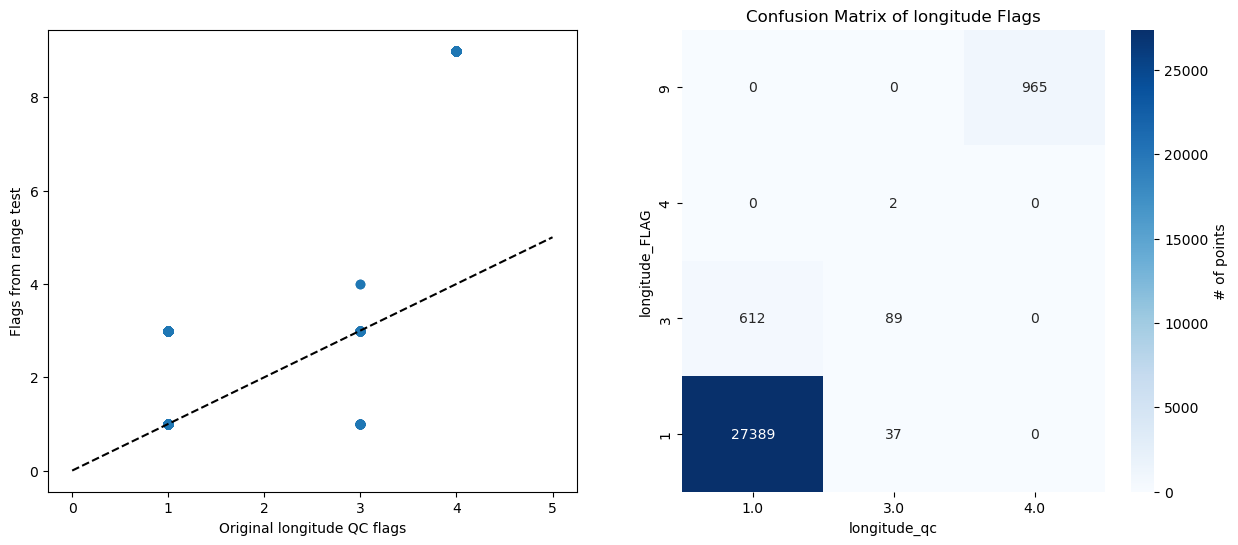

In [59]:
nrt[flagname].data = flags_final.data
conf_matrix = pd.crosstab(nrt[flagname], nrt[origflag])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].scatter(nrt[origflag], nrt[flagname])
axs[0].plot([0, 5], [0, 5], linestyle='--', color='k')
axs[0].set_ylabel('Flags from range test')
axs[0].set_xlabel(f'Original {varname} QC flags')

axs[1] = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
axs[1].set_xlabel(f'{origflag}')
axs[1].set_ylabel(f'{flagname}')
axs[1].set_title(f'Confusion Matrix of {varname} Flags')
axs[1].invert_yaxis()  #   So that 0 is at the bottom
cbar = axs[1].collections[0].colorbar
cbar.set_label('# of points')

In [60]:
varname = 'longitude'
x = np.arange(nrt.time.size)
y = nrt[varname].values
sus_idx = np.where(nrt[flagname].values == 3)[0]
bad_idx = np.where(nrt[flagname].values == 4)[0]
source = ColumnDataSource(data=dict(
    x=x,
    y=y,
))
p = figure(
    width=1000,
    height=600,
    x_axis_label="Sequential index",
    y_axis_label=varname,
    tools="pan,wheel_zoom,box_zoom,reset"
)
p.scatter('x', 'y', source=source, marker="+", size=8)
for i in sus_idx:
    vline = Span(location=i,
                 dimension='height',
                 line_dash='dashed',
                 line_color='blue',
                 line_width=1,
                 level='underlay')  # Ensure lines appear behind scatter
    p.add_layout(vline)
for i in bad_idx:
    vline = Span(location=i,
                 dimension='height',
                 line_dash='dashed',
                 line_color='red',
                 line_width=1,
                 level='underlay')
    p.add_layout(vline)

hover = HoverTool(tooltips=[
    ("Index", "@x"),
    (f"{varname}", "@y")
])
p.add_tools(hover)
show(p)

##  Pressure
Pressure is special for a number of reasons, mostly because it is the first recorded reading of the science package which comes from scientific instrumentation, i.e., not from NAV, which then is used to derive essentially every derived variable.

It is also important because it determines where in the Z domain the measurement is made. If doing intercomparisons, this will determine where your thermocline happens. Clines, almost by definition, are steep, so small changes in pressure can create *huge* discrepancies (a la IAPSO CTD intercomparisons).

Very important to get this right.

* Boundary min and max
* Check for insane descent rates (may indicate a failed sensor?). It should be differentiable and this will highlight major spikes.
* Confirm that `profile_direction` is equal to d/dt.

...

* Might want to confirm that there are not long periods where the glider is at the surface. Add a logging warning when P>10 dbar for over 30 minutes?

### Pressure range, dt, and nan checks

Text(0, 0.5, 'pressure')

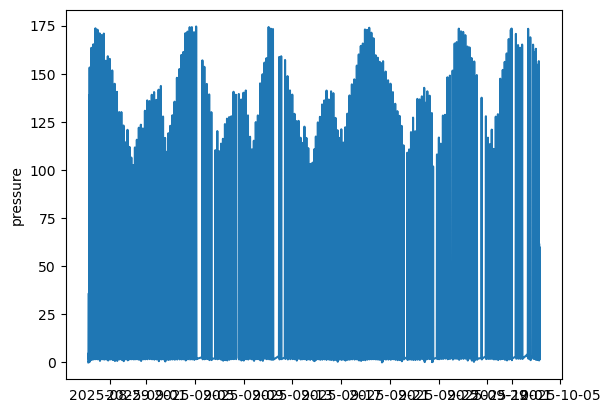

In [61]:
settings = load_settings()  #   Good to periodically reload this.
varname = 'pressure'
flagname= f"{varname}_FLAG"
origflag= f"{varname}_qc"
flags_range = flag_range(nrt[varname], nrt[flagname], settings[varname]["range"])   #   Argo says these flags should carry over to T, C
flags_diff = flag_diff(nrt[varname], nrt[flagname], settings[varname]["dt"])
flags_nan = flag_nan(nrt[varname], nrt[flagname])
plt.plot(nrt.time, nrt[varname], linestyle='-') #   This is what we're dealing with
plt.ylabel(varname)

194 total flags from current test


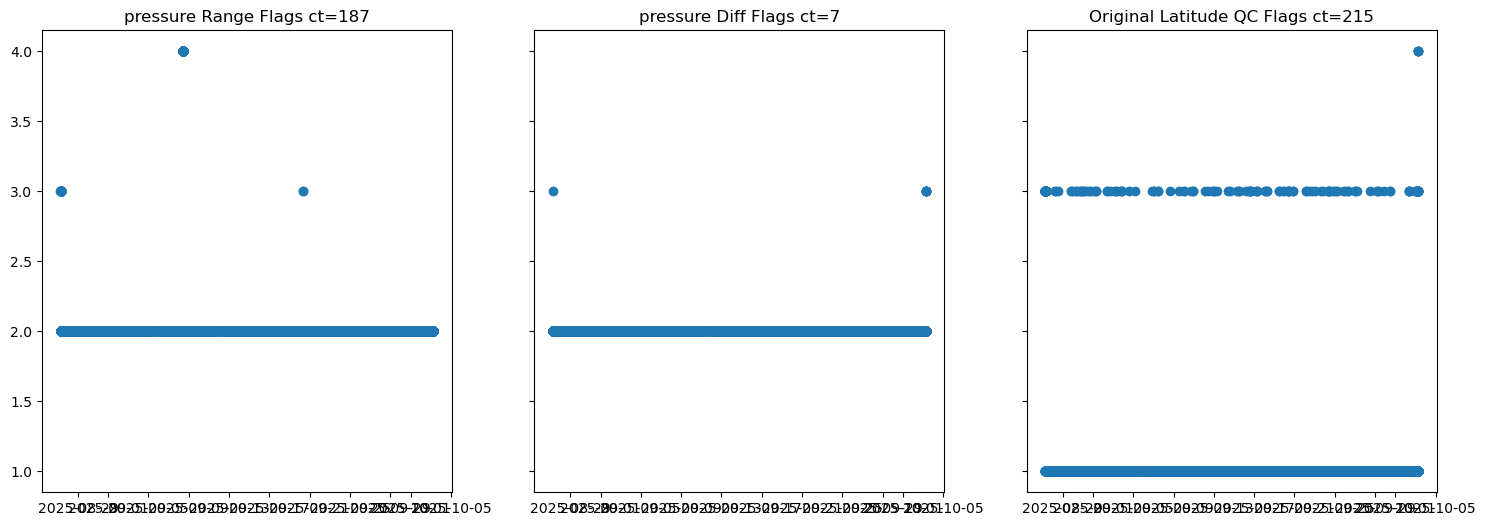

In [62]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
axs[0].scatter(nrt.time, flags_range.values)
axs[0].set_title(f'{varname} Range Flags ct={(flags_range != 2).sum().item()}')
axs[1].scatter(nrt.time, flags_diff.values)
axs[1].set_title(f'{varname} Diff Flags ct={(flags_diff != 2).sum().item()}')
axs[2].scatter(nrt.time, nrt[origflag])  #   Original flags, this one caught stuff.
axs[2].set_title(f'Original Latitude QC Flags ct={(nrt[origflag] != 1).sum().item()}') #  Ignore the "good"
print(f"{(flags_range != 2).sum().item()+(flags_diff != 2).sum().item()} total flags from current test")

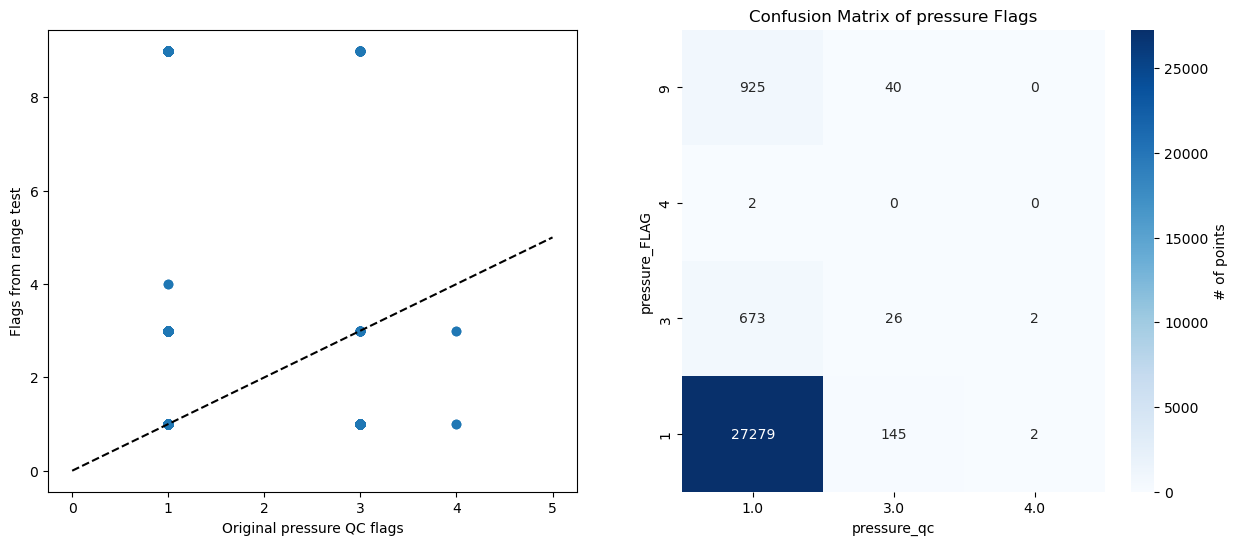

In [63]:
nrt[flagname].data = flags_final.data
conf_matrix = pd.crosstab(nrt[flagname], nrt[origflag])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].scatter(nrt[origflag], nrt[flagname])
axs[0].plot([0, 5], [0, 5], linestyle='--', color='k')
axs[0].set_ylabel('Flags from range test')
axs[0].set_xlabel(f'Original {varname} QC flags')

axs[1] = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
axs[1].set_xlabel(f'{origflag}')
axs[1].set_ylabel(f'{flagname}')
axs[1].set_title(f'Confusion Matrix of {varname} Flags')
axs[1].invert_yaxis()  #   So that 0 is at the bottom
cbar = axs[1].collections[0].colorbar
cbar.set_label('# of points')

In [64]:
varname = 'pressure'
x = np.arange(nrt.time.size)
y = nrt[varname].values
sus_idx = np.where(nrt[flagname].values == 3)[0]
bad_idx = np.where(nrt[flagname].values == 4)[0]
source = ColumnDataSource(data=dict(
    x=x,
    y=y,
))
p = figure(
    width=1000,
    height=600,
    x_axis_label="Sequential index",
    y_axis_label=varname,
    tools="pan,wheel_zoom,box_zoom,reset"
)
p.scatter('x', 'y', source=source, marker="+", size=8)
for i in sus_idx:
    vline = Span(location=i,
                 dimension='height',
                 line_dash='dashed',
                 line_color='blue',
                 line_width=1,
                 level='underlay')  # Ensure lines appear behind scatter
    p.add_layout(vline)
for i in bad_idx:
    vline = Span(location=i,
                 dimension='height',
                 line_dash='dashed',
                 line_color='red',
                 line_width=1,
                 level='underlay')
    p.add_layout(vline)

hover = HoverTool(tooltips=[
    ("Index", "@x"),
    (f"{varname}", "@y")
])
p.add_tools(hover)
show(p)

Argo 3.9 has an action that pressure values flagged based on gross range filters, not dp/dt, should be carried over to temperature and conductivity. I.e., if pressure is ~-5 dbar, it gets flagged 4, as does T and C for that point.

Might mean we need to initialize T and C relative to P if we like this flow.

### Pressure spikes
*However*, one thing we definitely want to implement on pressure that might not apply to time, lat, and lon, are pressure spikes. A gross range, or change in the range, is something that not only influences the glider position but also every derived variable.

For this reason, we should define some sort of rudimentary spike detection method.

Argo defines a filter below on page 13 of 3.9, which IMOS also uses (unchanged). It has been in use since at least 2013 (present in Argo 3.9), so it's a good method to get started with.
* TODO: Compare to SBE despike, as well as the median filter from scipy

$V_{value} = \lvert V_2 - \frac{(V_3 + V_1)}{2} \rvert - \lvert \frac{(V_3 - V_1)}{2} \rvert$


In [65]:
def flag_spikes(da, da_FLAG, limit: float) -> xr.DataArray:
    #   Set up rolling windows for Argo style spike detection
    rolled = da.rolling({da.dims[-1]: 3}, center=True).construct("window_dim")
    V1 = rolled.isel(window_dim=0)
    V2 = rolled.isel(window_dim=1)
    V3 = rolled.isel(window_dim=2)

    vvalue = np.abs(V2 - (V1 + V3)/2) - np.abs((V3 - V1)/2) #   Argo spike test formula
    flags = da_FLAG.copy()
    flags = flags.where(vvalue <= limit, other=4)  #   Fail flag

    if (flags != da_FLAG).sum().item() > 0:
        logger.info(f"Spike test flagged { (flags != da_FLAG).sum().item() } points in {da.name} exceeding limit {limit}.")

    return flags

In [66]:
settings = load_settings()  #   Good to periodically reload this.
spikes = flag_spikes(nrt.pressure, nrt.pressure_FLAG, settings['pressure']['spike'])

In [67]:
varname = 'pressure'
x = np.arange(nrt.time.size)
y = nrt[varname].values
bad_idx = np.where(spikes.values == 4)[0]
source = ColumnDataSource(data=dict(
    x=x,
    y=y,
))
p = figure(
    width=1000,
    height=600,
    x_axis_label="Sequential index",
    y_axis_label=varname,
    tools="pan,wheel_zoom,box_zoom,reset"
)
p.scatter('x', 'y', source=source, marker="+", size=8)
for i in bad_idx:
    vline = Span(location=i,
                 dimension='height',
                 line_dash='dashed',
                 line_color='red',
                 line_width=1,
                 level='underlay')
    p.add_layout(vline)

hover = HoverTool(tooltips=[
    ("Index", "@x"),
    (f"{varname}", "@y")
])
p.add_tools(hover)
show(p)

So, something nice is that this can identify different flags than the stuff before. These regions show a little overlap with the dt flags from before. However, it isn't clear how much of this is due to NaNs being present in the data. As such, more testing is needed.

TODO: Another test would be a loop editor. Look for spots where pressure goes up during the descent. We don't want to cut them out per se, as folks here are able to use them for good science, but it would be good to know where these loops are and maybe count how many we get. They could be indicative of very strong pycnoclines, rough conditions, or glider malfunctions.

## 4. Science Boundary Checks
Recall that we're running QC on a number of data streams and they don't all come from the same system.

Some are optical, so expect more spikiness or noise in those signals.

Some are partially derived, such as oxygen, which could have statistically compounding factors.

In [68]:
#   Recall we defined our core science variables earlier
print(core_science)
logger.info("Checking and assigning science boundary checks: Range, ddt, and NaN.")

['temperature', 'conductivity', 'oxygen_concentration', 'chlorophyll', 'phycocyanin', 'backscatter', 'downwelling_PAR']


Processing temperature...
Processing conductivity...
Processing oxygen_concentration...
Processing chlorophyll...
Processing phycocyanin...
Processing backscatter...
Processing downwelling_PAR...


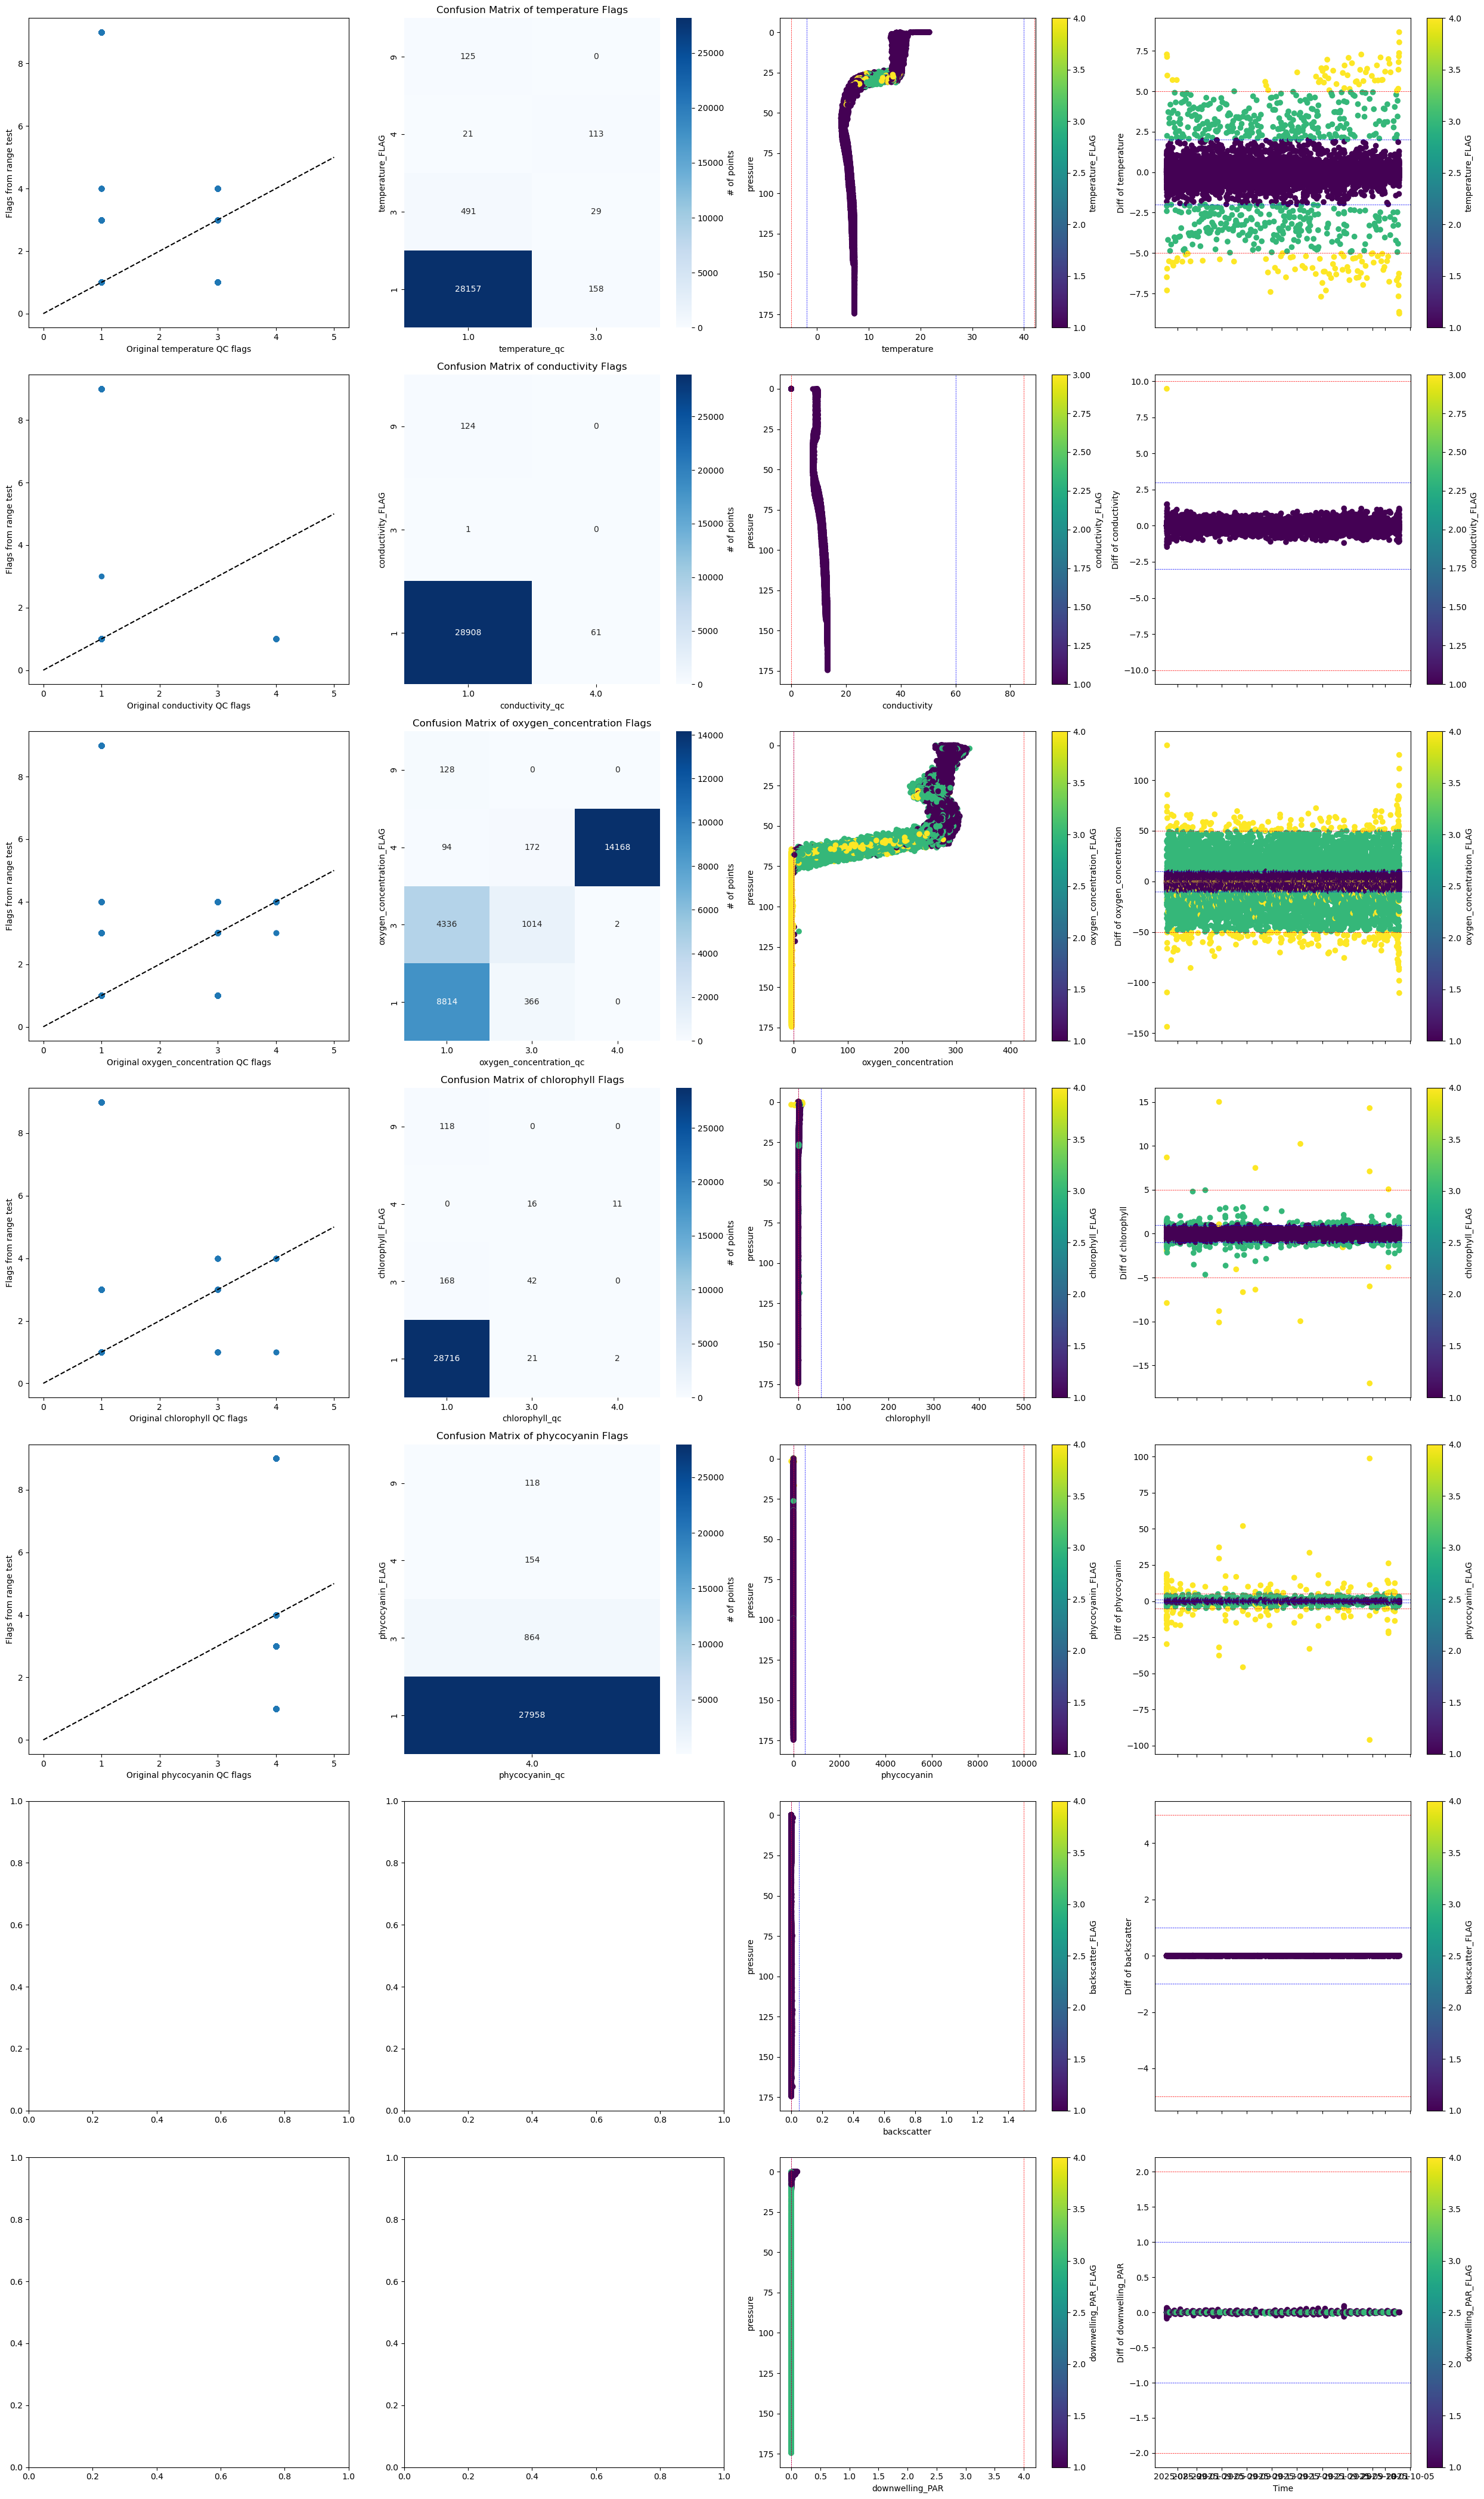

In [69]:
#   Loop through each variable and apply the tests
settings = load_settings()
fig, axs = plt.subplots(len(core_science), 4, figsize=(25, 6*len(core_science)))
plot_index = 0

for varname in core_science:
    print(f"Processing {varname}...")
    flagname= f"{varname}_FLAG"
    origflag= f"{varname}_qc"
    settings = load_settings()  #   Good to periodically reload this.
    flags_range = flag_range(nrt[varname], nrt[flagname], settings[varname]["range"])
    flags_diff = flag_diff(nrt[varname], nrt[flagname], settings[varname]["dt"])
    flags_nan = flag_nan(nrt[varname], nrt[flagname])
    
    flags_combined = apply_flags(nrt[flagname], flags_range)    #   Defaults to cascading flags, so the worst offenders will be kept
    flags_combined = apply_flags(flags_combined, flags_diff)    #   Second batch
    flags_combined = apply_flags(flags_combined, flags_nan)    #   Third batch
    flags_final = apply_flags(flags_combined, style='finalize')
    
    nrt[flagname].data = flags_final.data   #   Overwrite the initialized 2s with finalized flags (to view limits changes, you gotta reinit them)

    if origflag in nrt.variables:  #   Don't have QC on backscatter or downwelling_PAR yet
        conf_matrix = pd.crosstab(nrt[flagname], nrt[origflag])
        
        axs[plot_index, 0].scatter(nrt[origflag], nrt[flagname])
        axs[plot_index, 0].plot([0, 5], [0, 5], linestyle='--', color='k')
        axs[plot_index, 0].set_ylabel('Flags from range test')
        axs[plot_index, 0].set_xlabel(f'Original {varname} QC flags')
        
        # axs[plot_index, 1] = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[plot_index, 1])
        axs[plot_index, 1].set_xlabel(f'{origflag}')
        axs[plot_index, 1].set_ylabel(f'{flagname}')
        axs[plot_index, 1].set_title(f'Confusion Matrix of {varname} Flags')
        axs[plot_index, 1].invert_yaxis()  #   So that 0 is at the bottom
        cbar = axs[plot_index, 1].collections[0].colorbar
        cbar.set_label('# of points')
        
    #   Property plot of variable vs pressure, colored by flag
    axs[plot_index, 2].scatter(nrt[varname], nrt["pressure"], c=nrt[flagname], cmap='viridis', marker='o')
    axs[plot_index, 2].set_xlabel(varname)
    axs[plot_index, 2].set_ylabel('pressure')
    axs[plot_index, 2].invert_yaxis()
    
    cbar = axs[plot_index, 2].figure.colorbar(axs[plot_index, 2].collections[0], ax=axs[plot_index, 2])
    cbar.set_label(f'{flagname}')
    #   Now to visualize the limits in use for flagging
    for key, val in settings[varname]["range"].items():
        if key == "suspect":
            color = 'blue'
        elif key == "fail":
            color = 'red'
        for i in val:
            if i is not None:
                axs[plot_index, 2].axvline(i, linestyle='--', linewidth=0.5, color=color, zorder=1)

    #   Time series of diffs, colored by flag
    axs[plot_index, 3].scatter(nrt.time, np.concatenate(([np.nan], np.diff(nrt[varname]))), c=nrt[flagname], cmap='viridis', marker='o')
    if plot_index == len(core_science) - 1:
        axs[plot_index, 3].set_xlabel("Time")
    else:
        axs[plot_index, 3].set_xlabel("")
        axs[plot_index, 3].set_xticklabels([])
    axs[plot_index, 3].set_ylabel('Diff of ' + varname)
    cbar = axs[plot_index, 3].figure.colorbar(axs[plot_index, 3].collections[0], ax=axs[plot_index, 3])
    cbar.set_label(f'{flagname}')
    for key, val in settings[varname]["dt"].items():
        if key == "suspect":
            color = 'blue'
        elif key == "fail":
            color = 'red'
        for i in val:
            if i is not None:
                axs[plot_index, 3].axhline(i, linestyle='--', linewidth=0.5, color=color, zorder=1)

    # plt.suptitle(f'QC Flagging Results for {varname}')
    plt.tight_layout()
    plot_index += 1

What this tells me is that the manufacturer's specs are nowhere near useful enough for some of the new parameters.

It also shows that the `dt` tolerances could use some tweaking for NRT data - we're flagging the thermocline and oxycline!

## 5. Noise and Static

Assess if a signal is noisy or static

* Noise is often defined by standard deviations and can mask the base signal. This comes in the form of `white` noise, which appears like random jitter, or `disjointed` behavior, where a signal bounces between values.
    * This can have multiple ranges. If this standard deviation is within scientifcally-appropriate values, like noisy temperature within 0.5 deg C, then it can be flagged as 3 (as that likely exceeds manufacturer tolerances). However, noise that exceeds a stdev of 4 deg C is now too ambiguous to identify finer details from. That should be flagged as 4.
* Static signals are those where the value is congruent for each passing index in the time series and can start being flagged after a certain time period.
    * Static signals can come back and sometimes are real (detection limits can lead to 0V being passed back). If there are known static values (such as the offset value of a cal sheet), they should be defined in the settings to be ignored. All other instances of a sensor being static indicate a problem that otherwise detracts from the value of the water parcel.

In [70]:
logger.info("Checking sensor noise and static values...")

### Noise
From personal experience, checking noise is really hard when there are lots of big changes. It's usually easiest to do with a rolling standard deviation of a big window size. It is possible to map the data to a function and normalize relative to said function, but that might get really weird considering our gliders can have long pauses at the surface or don't always go all the way down.

Something to try in the future - isolating the up and down periods of the flight or **glider navigation state** as per the Alseamar SeaExplorer manual.
* 105 = Initializing
* 110 = Inflecting down (or rotating the nose down)
* **100 = Descending**
* 118 = Inflecting up (level at the bottom of the dive, pitch going positive from negative)
* **117 = Ascending**
* 115 = Surfacing (may overshoot)
* 116 = Transmitting NRT, not every single dive

Question for VOTO: Are these navigation states recorded? Is it reliable?
* If so, could use some detrend function based on the navigation state

In [71]:
#   I haven't been successful with these before - usually this requires a transform of some sort
def flag_noise(da, da_FLAG, limits: list, window: int) -> xr.DataArray:
    #   Flags data based on noise level within a rolling window
    rolled = da.rolling({da.dims[-1]: window}, center=True).construct("window_dim")
    noise = rolled.std(dim="window_dim")
    flags = da_FLAG.copy()
    s_limit, f_limit = limits

    if s_limit is not None:
        flags = flags.where(noise <= s_limit, other=np.maximum(flags, 3))
    if f_limit is not None:
        flags = flags.where(noise <= f_limit, other=4)

    if (flags != da_FLAG).sum().item() > 0:
        logger.info(f"Noise test flagged { (flags != da_FLAG).sum().item() } points in {da.name} exceeding limits {limits} (window size {window}).")

    return flags

The method above is a rolling stdev checker, which will flag based on the two limits passed in.

In [72]:
settings = load_settings()  #   Good to periodically reload this.
blank_flags = xr.DataArray(2 * np.ones_like(nrt.temperature), coords=nrt.temperature.coords, dims=nrt.temperature.dims)
noisy = flag_noise(nrt.temperature, blank_flags, settings['temperature']['noise'], window=3)

In [73]:
source = ColumnDataSource(data=dict(
    time=nrt.time.values,
    temperature=nrt.temperature.values,
    noisy=noisy.values
))

low_val = float(noisy.min().item())
high_val = float(noisy.max().item())
mapper = LinearColorMapper(palette=Viridis256, low=low_val, high=high_val)

p = figure(width=900, height=400, x_axis_type='datetime')
p.circle(
    'time', 'temperature', source=source, size=6,
    color=linear_cmap('noisy', Viridis256, low_val, high_val),
    line_color=None
)
color_bar = ColorBar(color_mapper=mapper, label_standoff=12, location=(0,0), title="Noise flag")
p.add_layout(color_bar, 'right')
show(p)
#   TODO: Learn bokeh scatter...

So it seems to be flagging a lot of the points where the glider is diving. I'm sure that's just because there aren't sufficient data points to really pull a reliable rolling stdev out.
* That being said, this isn't the best noise assessment, since we're going to be expecting values to change quickly across the thermocline and there are large gradients associated with that. This test is redoing the `dt` test to a certain extent by assessing a rate of change.
* *Could* modify this approach to handle a known slope or adjusting tolerances. We'll see.

### Static
Now for a static value check. This should just be a matter of checking for stuff that isn't changing (where our rolled min and max are the same).

In [74]:
def flag_static(da, da_FLAG, window: int = 10) -> xr.DataArray:
    rolled = da.rolling({da.dims[-1]: window}, center=True).construct("window_dim")
    static = rolled.max(dim="window_dim") == rolled.min(dim="window_dim") #   Not changing at all within window
    flags = da_FLAG.copy()
    flags = flags.where(~static, other=4)  #   Fail flag for static

    if (flags != da_FLAG).sum().item() > 0:
        logger.info(f"Static test flagged { (flags != da_FLAG).sum().item() } points in {da.name} (window size {window}).")


    return flags

In [75]:
settings = load_settings()  #   Good to periodically reload this.
blank_flags = xr.DataArray(2 * np.ones_like(nrt.temperature), coords=nrt.temperature.coords, dims=nrt.temperature.dims)
static = flag_static(nrt.temperature, blank_flags)

In [76]:
source = ColumnDataSource(data=dict(
    time=nrt.time.values,
    temperature=nrt.temperature.values,
    static=static.values
))

low_val = float(static.min().item())
high_val = float(static.max().item())
mapper = LinearColorMapper(palette=Viridis256, low=low_val, high=high_val)

p = figure(width=900, height=400, x_axis_type='datetime')
p.circle(
    'time', 'temperature', source=source, size=6,
    color=linear_cmap('static', Viridis256, low_val, high_val),
    line_color=None
)
color_bar = ColorBar(color_mapper=mapper, label_standoff=12, location=(0,0), title="static flag")
p.add_layout(color_bar, 'right')
show(p)

### Bonus functions for science
* Low pass filter
* FFT
* Window filter (Hann)
* Median filter

Just getting these in here as additional methods that we can eventually use, though they won't get used right away I think. Not going to test right now, as they require the highest frequency data and stuff without gaps (well, the first two do).

If folks at VOTO are curious to learn more, I can provide the other notebooks.

#### Low pass filter
Aaron has a long, verbose description of the SeaBird low-pass filter in a different notebook if more information is requested.

TODO: Explore Butterworth filter from `scipy.signal`. 

In [77]:
def sbe_lpf(x, dt=1/24, gamma=0.15):
    """
    Low-Pass Filter according to SBE definitions.
    """
    S0 = 1.0 / gamma
    alpha = 2 / (dt * S0)   #   For simplifying the definitions of A and B

    A = 1 / (1 + alpha)
    B = (1 - alpha) / (1 + alpha)

    y = np.zeros_like(x)
    y[0] = A * (x[0])   # initial condition for recursive stuff

    for n in range(1, len(x)):
        y[n] = A * (x[n] + x[n - 1]) - B * y[n - 1]
    
    # delta = x - y
    # lpf_flags = flag_by_difference(delta)
    # report flags to logger
    return # lpf_flags

#### Fast Fourier Transform
Note: This **cannot** be done on NRT. Requires evenly spaced time data.

A good way to pull out frequncy problems in the data, such as tide or ship heave (was good for CTDs). Subtracting out high F noise can be a form of noise detection without requiring a detrend function.

We also want to see the power spectral density diagrams to see what frequencies in the data we're dealing with. Expect seasonality over long timeframes, but a single deployment won't see as much considering how high F we're recording over the course of 4+ weeks.

In [78]:
#   Doesn't work on NRT due to the data gaps
def flag_fft(da, da_time, da_FLAG, tolerance, f_out = None):
    if da.isnull().any().item() or da_time.isnull().any().item():
        logger.warning("Found NaNs in FFT calculation. Exiting calculation.")
        return
    f = da.to_numpy()
    t = da_time.to_numpy().astype('int64')
    n = len(t)

    fhat = np.fft.fft(f,n)  #   Fourier coefficients (magnitude of each frequency that comprises the signal)
    PSD = fhat * np.conj(fhat) / n  #   Power spectral density

    indices = PSD > tolerance   #   A vector to find peaks within our tolerance
    # PSDclean = PSD * indices    #   Zero out frequencies that don't hit our tolerance - useful if plotting how it is cleaned
    fhat_new = indices * fhat       #   Zero out small Fourier coefficients in original singal
    ffilt = np.fft.ifft(fhat_new)
    delta = f-ffilt  #   If positive, ffilt is *lower* than f
    if f_out is not None:   #   Subfunction - plot fft
        dt = np.mean(np.diff(t))    #   Get the approximate data frequncy
        freq = (1/(dt*n)) * np.arange(n)    #   X-axis frequencies
        plt.plot(freq, PSD.real, color='c', linewidth=2, label='Noisy')
        plt.yscale('log')
        plt.ylabel('PSD "power" in the signal')
        plt.xlabel('Power spectrum (frequency, Hz)')
        plt.legend()

        fig, axs = plt.subplots(2,1)

        plt.sca(axs[0])
        plt.plot(t, f, color='c', linewidth=1.5,label='noisy')
        plt.plot(t, ffilt, color='k', linewidth=1.5, label='filtered')
        plt.xlabel('Time')
        plt.legend()

        plt.sca(axs[1])
        plt.plot(t, delta, color='c', linewidth=1.5,label='Difference f-ffilt')
        plt.ylabel(f'Filter offset on {f.attrs['long_name']}')
        plt.xlabel('Time')
        plt.legend()
    # fft_flags = flag_by_difference(delta)
    # report_flag_outputs_to_logger
    return # fft_flags

#### Window filters
Aaron did experiments on CTD data and saw the ODF was using the Hann filter to best effect.

In [79]:
def flag_wfilter(da, model, win_size, f_out=None):
    #   Win size should be a function of sensor frequency. 24 Hz sensors can be 48... 96...
    if model == "boxcar":
        window = sig.windows.boxcar(win_size)
    elif model == "cosine":
        window = sig.windows.boxcar(win_size)
    elif model == "hann":
        window = sig.windows.boxcar(win_size)
    elif model == "triang":
        window = sig.windows.boxcar(win_size)
    filtered = sig.convolve(da, window, mode="same") / np.sum(window)
    delta = da - filtered

    # wfilt_flags = flag_by_difference(delta)
    # report_flag_outputs_to_logger
    if f_out:   #   This should be a function
        fig, ax = plt.subplots()
        ax.plot(nrt.time, delta)
        plt.xlabel("Timestamp")
        ax.tick_params(axis='x', rotation=30)
        plt.ylabel(f"Δ {da.attrs["long_name"]} {da.attrs["units"]}")
        plt.title("Temperature Difference from Median Filtered Signal")
        ax.axhline(y=0.5, linestyle=":", linewidth=1)   #   Completely arbitrary tolerances that will definitely change
        ax.axhline(y=-0.5, linestyle=":", linewidth=1)
    return #wfilt_flags

#### Median filter
Something that SeaBird supports. It's nice that it is able to do both a despike and a filter to a certain extent.

In [80]:
def flag_median(da, win_size: int=5, make_plot=False) -> xr.DataArray:
    filtered = ndi.median_filter(da, size=win_size)
    delta = da - filtered
    # med_filt_flags = flag_by_difference(delta)
    # report_flag_outputs_to_logger
    if make_plot:
        fig, ax = plt.subplots()
        ax.plot(nrt.time, delta)
        plt.xlabel("Timestamp")
        ax.tick_params(axis='x', rotation=30)
        plt.ylabel(f"Δ {da.attrs["long_name"]} {da.attrs["units"]}")
        plt.title("Temperature Difference from Median Filtered Signal")
        ax.axhline(y=0.5, linestyle=":", linewidth=1)   #   Completely arbitrary tolerances that will definitely change
        ax.axhline(y=-0.5, linestyle=":", linewidth=1)
    return #med_filt_flags

## 6. Despiker methods to test
A few immediate examples come to mind that should be tested in the future.

* Argo's despike algorithm, which is already defined above.
* SeaBird Scientific's approach, called [wild_edit](https://github.com/Sea-BirdScientific/seabirdscientific/blob/main/src/seabirdscientific/processing.py)
* Dan Kelley's [OCE algorithm](https://github.com/dankelley/oce/blob/develop/R/misc.R), written in R
* IOOS QARTOD [spike_check](https://ioos.github.io/qartod/_modules/ioos_qartod/qc_tests/qc.html#spike_check)

Some despiking is done almost by definition of the median filter, since it isn't using a mean on any of the data.


SeaBird Scientific's outlier/spike remover.

In [81]:
#   SBE functions for despike. Subject to testing on delayed dataset.
FLAG_VALUE = -9.99e-29
def wild_edit(
    data: np.ndarray,
    flags: np.ndarray,
    std_pass_1: float,
    std_pass_2: float,
    scans_per_block: int,
    distance_to_mean: float,
    exclude_bad_flags: bool,
    flag_value=FLAG_VALUE,
) -> np.ndarray:
    """Flags outliers in a dataset.

    Outliers are flagged by iterating over the data in blocks, taking
    the mean and standard deviation, and flagging data outside the
    combined variance (standard deviation of the block multiplied by the
    standard deviation argument). Each block is processed three times:
    first to remove loop edit flags if applicable, second to temporarily
    remove outliers outside std_pass_1, third to remove outliers outside
    std_pass_2 from the returned data.

    If the final block contains fewer samples than scans_per_block, data
    is backfilled from the previous block before computing the mean and
    standard deviation.

    This algorithm may introduce nonlinearities in the data because it
    runs one block at a time instead of a rolling window. This is done
    to maintain parity with SBE Data Processing.

    :param data: The data to be flagged, such as temperature or pressure
    :param flags: Flag data from loop edit
    :param std_pass_1: Standard deviation for the first pass
    :param std_pass_2: Standard deviation for the second pass
    :param scans_per_block: Number of samples to process in each block
    :param distance_to_mean: Minimum threshod to flag data. Values
        within this range to mean are kept even if their standard
        deviation is outside the limit
    :param exclude_bad_flags: Excludes all loop edit flags
    :param flag_value: The flag value written in place
        of data. Defaults to -9.99e-29.

    :return: The data with flag values in place of outliers
    """

    lower_index = 0
    upper_index = scans_per_block
    flagged_data = data.copy()

    while upper_index <= len(data):
        flagged_data[lower_index:upper_index] = _flag_data(
            data[lower_index:upper_index],
            flags,
            std_pass_1,
            std_pass_2,
            distance_to_mean,
            exclude_bad_flags,
            flag_value,
        )
        lower_index += scans_per_block
        upper_index += scans_per_block

    if lower_index < len(data):
        lower_index = len(data) - scans_per_block
        upper_index = len(data)
        flagged_data[len(data) - len(data) % scans_per_block :] = _flag_data(
            data[lower_index:upper_index],
            flags,
            std_pass_1,
            std_pass_2,
            distance_to_mean,
            exclude_bad_flags,
            flag_value,
        )[scans_per_block - len(data) % scans_per_block :]

    return flagged_data


def _flag_data(
    data: np.ndarray,
    flags: np.ndarray,
    std_pass_1: float,
    std_pass_2: float,
    distance_to_mean: float,
    exclude_bad_flags: bool,
    flag_value=FLAG_VALUE,
) -> np.ndarray:
    """Helper function for wild_edit() that handles the three main loops

    :param data: The data to be flagged, such as temperature or pressure
    :param flags: Flag data from loop edit
    :param std_pass_1: Standard deviation for the first pass
    :param std_pass_2: Standard deviation for the second pass
    :param distance_to_mean: Minimum threshod to flag data. Values
        within this range to mean are kept even if their standard
        deviation is outside the limit
    :param exclude_bad_flags: Excludes all loop edit flags
    :param flag_value: The flag value written in place of data. Defaults
        to -9.99e-29.

    :return: The data with flag values in place of outliers
    """

    data_copy = pd.Series(data.copy())
    flagged_data = data.copy()

    for n, value in enumerate(data_copy):
        if exclude_bad_flags and flags[n] == flag_value:
            data_copy[n] = np.nan

    mean = data_copy.mean()
    std = data_copy.std()

    for n, value in enumerate(data_copy):
        if abs(value - mean) >= std * std_pass_1:
            data_copy[n] = np.nan

    mean = data_copy.mean()
    std = data_copy.std()

    for n, value in enumerate(flagged_data):
        if abs(value - mean) > std * std_pass_2 and abs(value - mean) > distance_to_mean:
            flagged_data[n] = flag_value

    return flagged_data

OCE Despike method

In [82]:
#   Then Dan Kelley's R code, translated to Python
#   1. Linearly interpolate over NaNs
#   a. 'median' Establish a median filter and define cutoff distances
#   b. 'smooth' R has smoothing splines. Not sure if we want to use that. MATLAB PCHIP equivalent in Python would have fewer asymptotal tendencies. Would need lots of testing.
#   c. 'trim' Straight up throw out values that spike outside of a window. Not really a despiker...

import numpy as np
import xarray as xr
from scipy.interpolate import interp1d
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter1d

def despike(
    x,
    da_FLAG,
    reference="median",   # 'median', 'smooth', 'trim'
    n=4,    #   His ranges. n = spike detection threshold multiplier
    k=7,    #   Median filter window size
    min_val=None,
    max_val=None,
    logger=None
):
    """
    Flag spikes in a 1D signal, following the logic of OCE::despikeColumn.
    Returns a QC flag array (4=spike).
    """

    #   Numpy is so much easier than Xarray - do this for all functions in the future
    is_xarray = isinstance(x, xr.DataArray)
    if is_xarray:
        data = x.values.astype(float).copy()
    else:
        data = np.asarray(x, dtype=float).copy()

    nx = data.size
    i = np.arange(nx)

    #   Interpolate over NaNs
    na = np.isnan(data)
    if na.any():
        f = interp1d(i[~na], data[~na], kind="linear", fill_value="extrapolate")
        gapless = f(i)
    else:
        gapless = data.copy()

    #   Dan's version of median filter
    if reference == "median":
        # Running median
        k_eff = k if k % 2 == 1 else k + 1  # kernel must be odd for medfilt
        ref = medfilt(gapless, kernel_size=k_eff)

        distance = np.abs(gapless - ref)
        stddev = np.sqrt(np.nanvar(distance))
        bad = distance > n * stddev

    #   SMOOTH
    elif reference == "smooth":
        #   Gaussian smoother approximates R's smooth.spline
        #   TODO: Find PCHIP ddt limited spline
        ref = gaussian_filter1d(gapless, sigma=k/3)
        distance = np.abs(gapless - ref)
        stddev = np.sqrt(np.nanvar(distance))
        bad = distance > n * stddev

    #   TRIM mode
    elif reference == "trim":
        if min_val is None or max_val is None:
            raise ValueError("trim mode requires min_val and max_val")
        bad = ~((data >= min_val) & (data <= max_val))
        ref = None  # not needed for flagging

    flags = da_FLAG.copy()
    flags[bad] = 4

    if logger is not None:
        nbad = np.sum(bad)
        logger.info(
            f"Despike: method={reference}, size={nx}, spikes={nbad}, "
            f"fraction={nbad/nx:.3f}"
        )

    #   Return as xarray if input was xarray
    if is_xarray:
        return xr.DataArray(flags, coords=x.coords, dims=x.dims, name=f"{x.name}_despike_flags")
    else:
        return flags


IOOS QARTOD method, which I think we're currently using.

In [83]:
class QCFlags:
    """Primary flags for QARTOD."""
    # Don't subclass Enum since values don't fit nicely into a numpy array.
    GOOD_DATA = 1
    UNKNOWN = 2
    SUSPECT = 3
    BAD_DATA = 4
    MISSING = 9
def set_prev_qc(flag_arr, prev_qc):
    """Takes previous QC flags and applies them to the start of the array
       where the flag values are not unknown.

       :param flag_arr: An array of flag values
       :param prev_qc: An array of previous QC values corresponding to the start
                       postition of flag_arr
       """
    cond = prev_qc != QCFlags.UNKNOWN
    flag_arr[cond] = prev_qc[cond]
def spike_check(arr, low_thresh, high_thresh, prev_qc=None):
    """
    Determine if there is a spike at data point n-1 by subtracting
    the midpoint of n and n-2 and taking the absolute value of this
    quantity, seeing if it exceeds a a low or high threshold.
    Values which do not exceed either threshold are flagged good,
    values which exceed the low threshold are flagged suspect,
    and values which exceed the high threshold are flagged bad.
    
    The flag is set at point n-1.
    
    :param arr: The input array of values
    :param low_thresh: The low value threshold
    :param high_threshold: The high threshold value
    :param prev_qc: An array of any previous QC values which were applied.  The first element is assumed to correspond to the position of the first element of arr
    """
    # Subtract the average from point at index n-1 and get the absolute value.
    if low_thresh >= high_thresh:
        raise ValueError("Low theshold value must be less than high threshold "
                         "value.")
    val = np.abs(np.convolve(arr, [-0.5, 1, -0.5], mode='same'))
    # First and last elements can't contain three points,
    # so set difference to zero so these will avoid getting spike flagged.
    val[[0, -1]] = 0
    flag_arr = ((val < low_thresh) +
                ((val >= low_thresh) & (val < high_thresh)) * QCFlags.SUSPECT +
                (val >= high_thresh) * QCFlags.BAD_DATA)
    if prev_qc is not None:
        set_prev_qc(flag_arr, prev_qc)
    return flag_arr

## 8. Point Flag assignment
Point Flags are used to define if data, in general at some 4D position or _point_, are good.

Basically, was there some problem at the point that makes the entire point worth using? For example, the phycocyanin sensor can be trash, as can the oxygen, but the CTD itself can be fine. As such, the individual sensor flags (primary flags, derived from a number of secondary flags) may be bad for the phycocyanin and oxygen, but the Point Flag can be good.
* Lat, lon, pressure, and time, in my mind, should be the primary determinants of if a Point Flag is bad. If you don't know where the data was taken, it carries no scientific value
    * "Oh I took a reading and the oxygen was 600 umol/kg"
    * "Wow, that's higher than I've ever seen at this spot! When did you see it? Was it during a bloom?"
    * "Oh, I don't know."
    * :/
* Next, there are the essential variables to density, namely pressure, temperature, and conductivity, which are used for derivations of numerous BGC parameters. Gas saturation, sound velocity, ADCP readings, all derive from density to a certain extent. For that reason, if any of these are bad, then density will be bad, as will all of these other derived variables.

In [84]:
logger.info("Assigning point flags...")
flag_vars = [
    "time_FLAG",
    "pressure_FLAG",
    "latitude_FLAG",
    "longitude_FLAG",
    "temperature_FLAG",
    "conductivity_FLAG",
]

In [85]:
flags = xr.concat([nrt[v] for v in flag_vars], dim="flag_type")
flags = flags.assign_coords(flag_type=flag_vars)
xr_describe(flags)

{'count': 174564,
 'mean': 1.175861002268509,
 'std': 1.09181364175317,
 'min': 1,
 '25%': 1.0,
 '50%': 1.0,
 '75%': 1.0,
 'max': 9}

In [86]:
print(pd.DataFrame(flags))  #   NaN flags for pressure, lat, and lon at the beginning. 3s and 4s at the end for various sensors.

   0      1      2      3      4      5      6      7      8      9      ...  \
0      1      1      1      1      1      1      1      1      1      1  ...   
1      1      9      9      9      9      9      9      9      9      9  ...   
2      1      9      9      9      9      9      9      9      9      9  ...   
3      1      9      9      9      9      9      9      9      9      9  ...   
4      1      1      1      1      1      1      1      1      1      1  ...   
5      1      1      1      1      1      1      1      1      1      1  ...   

   29084  29085  29086  29087  29088  29089  29090  29091  29092  29093  
0      1      1      1      1      1      1      1      1      1      1  
1      1      3      3      3      3      3      3      3      1      3  
2      1      1      1      1      1      1      1      1      1      3  
3      1      3      3      3      3      3      3      3      1      3  
4      1      1      4      1      1      1      1      1      1     

In [87]:
nrt["point_FLAG"] = flags.max(dim="flag_type")  #   Collapse it down

In [88]:
for fv in flag_vars:    #   Report to the logger
    contributed = nrt[fv] == nrt["point_FLAG"]  #   When the flag value of that variable is equal to the max seen
    count = contributed.sum().item()
    logger.info(f"point_FLAG: {count} indexes where {fv} contributed to point_FLAG variable.")

In [89]:
nrt[fv]

<xarray.DataArray 'conductivity_FLAG' (time: 29094)> Size: 29kB
array([1, 1, 1, ..., 1, 1, 1], shape=(29094,), dtype=int8)
Coordinates:
  * time       (time) datetime64[ns] 233kB 2025-08-27T06:28:55.004999936 ... ...
    latitude   (time) float64 233kB 58.09 nan nan nan ... 58.12 58.12 58.12
    longitude  (time) float64 233kB 19.73 nan nan nan ... 19.78 19.78 19.79
    depth      (time) float64 233kB -0.04448 -0.04855 -0.04884 ... 1.968 1.989

Now to look at spots where there is more than one issue with the point. These should be brought to the operator's attention.

In [90]:
problem_flags = flags > 2
num_problems = problem_flags.sum(dim="flag_type")   #   Sum areas where flags are problematic
indices = np.where((num_problems > 1).values)[0]    #   Return idx where there is more than one problem with the point
logger.info(f"point_FLAG: {len(indices)} total indexes with multiple problems.")
for idx in indices:
    vars_here = flags.flag_type.values[problem_flags[:, idx].values]
    logger.info(
        f"point_FLAG: index {idx} has multiple problems {list(vars_here)}"
    )

Visualize the problem spots

In [91]:
source = ColumnDataSource({
    "lat": nrt["latitude"].values,
    "lon": nrt["longitude"].values,
    "flag": nrt["point_FLAG"].values.astype(str),   # color mapper expects strings if using discrete categories
    "time_FLAG": nrt["time_FLAG"].values,
    "pressure_FLAG": nrt["pressure_FLAG"].values,
    "latitude_FLAG": nrt["latitude_FLAG"].values,
    "longitude_FLAG": nrt["longitude_FLAG"].values,
    "temperature_FLAG": nrt["temperature_FLAG"].values,
    "conductivity_FLAG": nrt["conductivity_FLAG"].values,
    "index": np.arange(len(nrt["point_FLAG"]))
})

flag_values = sorted(list(set(source.data["flag"])))

palette = Category10[max(3, len(flag_values))]  #   Category10 goes up to 10 entries
color_mapper = CategoricalColorMapper(factors=flag_values, palette=palette)

p = figure(
    width=700,
    height=500,
    x_axis_label="Longitude",
    y_axis_label="Latitude",
    tools="pan,wheel_zoom,reset,save"
)

p.scatter(
    x="lon",
    y="lat",
    source=source,
    size=6,
    fill_color={"field": "flag", "transform": color_mapper},
    line_color=None,
)

# Hover showing index + flags
hover = HoverTool(
    tooltips=[
        ("index", "@index"),
        ("point_FLAG", "@flag"),
        ("time_FLAG", "@time_FLAG"),
        ("pressure_FLAG", "@pressure_FLAG"),
        ("latitude_FLAG", "@latitude_FLAG"),
        ("longitude_FLAG", "@longitude_FLAG"),
        ("temperature_FLAG", "@temperature_FLAG"),
        ("conductivity_FLAG", "@conductivity_FLAG"),
    ]
)
p.add_tools(hover)
show(p)

In [92]:
#   Should make this into an exportable figure function.
density = nrt["density"]
source = ColumnDataSource({
    "pres": nrt["pressure"].values,
    "rho": density.values,
    "flag": nrt["point_FLAG"].values.astype(str),   # color mapper expects strings if using discrete categories
    "time_FLAG": nrt["time_FLAG"].values,
    "pressure_FLAG": nrt["pressure_FLAG"].values,
    "latitude_FLAG": nrt["latitude_FLAG"].values,
    "longitude_FLAG": nrt["longitude_FLAG"].values,
    "temperature_FLAG": nrt["temperature_FLAG"].values,
    "conductivity_FLAG": nrt["conductivity_FLAG"].values,
    "index": np.arange(len(nrt["point_FLAG"]))
})

flag_values = sorted(list(set(source.data["flag"])))

palette = Category10[max(3, len(flag_values))]  #   Category10 goes up to 10 entries
color_mapper = CategoricalColorMapper(factors=flag_values, palette=palette)

p = figure(
    width=700,
    height=500,
    x_axis_label="Density (not rederived)",
    y_axis_label="Pressure",
    tools="pan,wheel_zoom,reset,save"
)

p.scatter(
    x="rho",
    y="pres",
    source=source,
    size=6,
    fill_color={"field": "flag", "transform": color_mapper},
    line_color=None,
)

# Hover showing index + flags
hover = HoverTool(
    tooltips=[
        ("index", "@index"),
        ("point_FLAG", "@flag"),
        ("time_FLAG", "@time_FLAG"),
        ("pressure_FLAG", "@pressure_FLAG"),
        ("latitude_FLAG", "@latitude_FLAG"),
        ("longitude_FLAG", "@longitude_FLAG"),
        ("temperature_FLAG", "@temperature_FLAG"),
        ("conductivity_FLAG", "@conductivity_FLAG"),
    ]
)
p.add_tools(hover)
p.y_range.flipped = True
show(p)

##  9. Linear Regressions and property-property plots
We can do regressions on some of these plots to make sure that parameters are behaving as we expect. I.e., we do not expect density to have inversions 
* so rho vs pressure should be directly proportional for all points
* Want to see chlorophyll vs oxygen
* AOU and oxygen saturation would be nice to have for biological reasons, too
    * Can do % agreement statistics
* Want to estimate MLD as well as chlorophyll max - we would expect to see them align
* Does phycocycanin correlate with chlorophyll, especially since it's a type of fluorescent compound?
* Chlorophyll and backscatter should correlate
* Plot derived characteristics vs their sources
    * Depending on data sources, can overwrite these flags
    * This is where we could do some TEOS10 expected plots from actual logged stuff
* SVP might be interesting to see, when compared to density

In [94]:
nrt["temperature_qc"].attrs

{'ioos_qc_module': 'qartod',
 'quality_control_conventions': 'IOOS QARTOD standard flags',
 'quality_control_set': np.int64(1),
 'valid_min': np.int8(1),
 'valid_max': np.int8(9),
 'flag_values': array([1, 2, 3, 4, 9]),
 'flag_meanings': 'GOOD, UNKNOWN, SUSPECT, FAIL, MISSING',
 'long_name': 'quality control flags for water temperature',
 'standard_name': 'sea_water_temperature_flag',
 'comment': 'Quality control flags from IOOS QC QARTOD https://github.com/ioos/ioos_qc Version: 2.1.0. Using config: [<Call stream_id=temperature function=qartod.gross_range_test(suspect_span=[0, 30], fail_span=[-2.5, 40])>, <Call stream_id=temperature function=qartod.spike_test(suspect_threshold=2.0, fail_threshold=6.0)>, <Call stream_id=temperature function=qartod.location_test(bbox=[7, 53, 26, 65])>].  Threshold values from EuroGOOS DATA-MEQ Working Group (2010) Recommendations for in-situ data Near Real Time Quality Control [Version 1.2]. EuroGOOS, 23pp. DOI http://dx.doi.org/10.25607/OBP-214.'}